# FROUROS

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from frouros.detectors.data_drift import KSTest
from frouros.detectors.data_drift import PSI
from frouros.detectors.data_drift import KL
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from menelaus.datasets import make_example_batch_data

In [4]:
df = make_example_batch_data()

In [5]:
df

,year,a,b,c,d,e,f,g,h,i,j,cat,confidence,drift
0,2007,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492,2,0.591243,False
1,2007,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540,2,0.196090,False
2,2007,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082,1,0.504019,False
3,2007,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312,2,0.487307,False
4,2007,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074,1,0.211284,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,2021,8434.682418,203.931217,8674.083920,104317.953759,-1.588765,-1.313684,165132.657078,284.979440,7065.994173,83.803525,2,0.641595,True
299996,2021,9701.660570,179.925659,8021.128673,63749.091322,0.412063,0.408188,124630.300901,323.602163,10960.392248,96.796410,1,0.467875,True
299997,2021,6928.908424,210.007943,3312.751778,126116.364855,0.113971,2.432577,107318.127090,214.452933,9491.057615,169.644626,2,0.787726,True
299998,2021,6410.255420,205.092167,6914.861179,158221.742954,0.060710,0.928108,71610.603448,570.911317,8577.498702,61.404365,0,0.689538,True


This function returns a dataframe containing synthetic batch data for use with the repo’s examples. The dataframe’s columns are "year", "a", "b", ... "j", "cat", "confidence", "drift".

- year covers 2007-2021, with 20,000 observations each.

- Features "b", "e", "f" are normally distributed.

- Features "a", "c", "d", "g", "h", "i", "j" have a gamma distribution.

- The "cat" feature contains categorical variables ranging from 1-7, sampled with varying probability.

- "confidence" contains values on [0, 0.6] through 2018, then values on [0.4, 1].

Drift occurs as follows:

- Change the mean of column "b" in 2009. Reverts to original distribution in 2010.

- Change the variance of columns "c" and "d" in 2012 by replacing some samples with the mean. Reverts to original distribution in 2013.

- Increase the correlation of columns "e" and "f" in 2015 (0 correlation to 0.5 correlation).

- Change the mean and variance of column "h" in 2019, and maintain this new distribution going forward. Change the range of the “confidence” column going forward.

- Change the mean and variance of column "j" in 2021.

In [6]:
df = df.iloc[:, 1:-3]

In [7]:
df

,a,b,c,d,e,f,g,h,i,j
0,5036.441154,198.936685,6995.029198,133187.697950,0.402750,-1.339692,90453.457231,8819.761759,5398.861764,1059.835492
1,10773.027107,179.260652,3467.970499,52174.100900,1.019491,-1.145258,72629.507052,10137.233887,7009.344647,1552.888540
2,6173.596856,199.775829,4921.472906,101848.950792,-2.248839,1.903668,54839.516587,9603.709193,10579.518133,856.266082
3,13208.612929,182.222072,9638.632797,92442.165726,-0.045599,1.106212,84447.758390,12511.305427,5618.433039,451.926312
4,2719.272009,213.028454,5501.439179,79155.846985,-1.602719,-1.368130,168769.099013,16034.259622,6214.909756,853.582074
...,...,...,...,...,...,...,...,...,...,...
299995,8434.682418,203.931217,8674.083920,104317.953759,-1.588765,-1.313684,165132.657078,284.979440,7065.994173,83.803525
299996,9701.660570,179.925659,8021.128673,63749.091322,0.412063,0.408188,124630.300901,323.602163,10960.392248,96.796410
299997,6928.908424,210.007943,3312.751778,126116.364855,0.113971,2.432577,107318.127090,214.452933,9491.057615,169.644626
299998,6410.255420,205.092167,6914.861179,158221.742954,0.060710,0.928108,71610.603448,570.911317,8577.498702,61.404365


In [8]:
n_ref = 20000
X_ref, X_t0= df[:n_ref], df[n_ref:]

In [9]:
def batch_generator(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]
def plot_drift_detection(years, p_values, feature_name):
    plt.plot(years, p_values)
    plt.axhline(y=0.01, color='y', linestyle='--', label='Threshold')
    for i, p in enumerate(p_values):
        if p < 0.01:
            plt.plot(years[i], p, 'ro')
            plt.text(years[i], p, 'Drift', fontsize=9, verticalalignment='bottom', horizontalalignment='right', color='r')
    
    plt.xlabel('Años')
    plt.ylabel('P_value')
    plt.title(f'Detección de Drift para la característica "{feature_name}"')
    plt.show()

### KS Test

FEATURE  a


No se detectó drift en el año 2008 con un p-valor de 0.4257468753812901
No se detectó drift en el año 2009 con un p-valor de 0.666519467755871
No se detectó drift en el año 2010 con un p-valor de 0.7250736496496843
No se detectó drift en el año 2011 con un p-valor de 0.39043921203312104
No se detectó drift en el año 2012 con un p-valor de 0.3701387077974301
No se detectó drift en el año 2013 con un p-valor de 0.797170795694494
No se detectó drift en el año 2014 con un p-valor de 0.20092759723782394
No se detectó drift en el año 2015 con un p-valor de 0.5992071991851593
No se detectó drift en el año 2016 con un p-valor de 0.6833544902047151
No se detectó drift en el año 2017 con un p-valor de 0.6243741569816843
No se detectó drift en el año 2018 con un p-valor de 0.8936027987210781
No se detectó drift en el año 2019 con un p-valor de 0.09388586619964923
No se detectó drift en el año 2020 con un p-valor de 0.8484821982318688
No se detectó drift en el año 2021 con un p-valor 

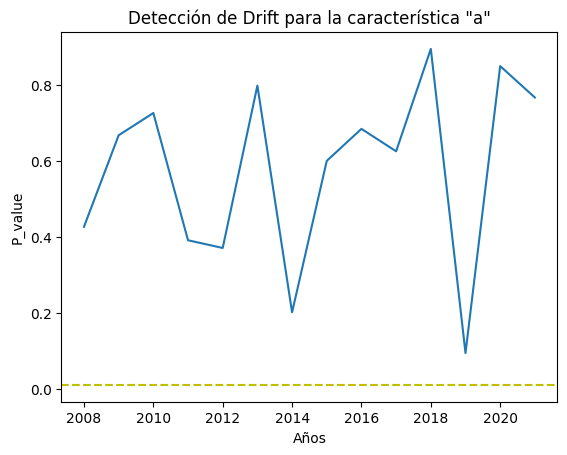

FEATURE  b


No se detectó drift en el año 2008 con un p-valor de 0.4627985754334213
Drift detectado en el año 2009 con un p-valor de 0.0
No se detectó drift en el año 2010 con un p-valor de 0.2845697471186103
No se detectó drift en el año 2011 con un p-valor de 0.7894417405334433
No se detectó drift en el año 2012 con un p-valor de 0.17257469583557783
No se detectó drift en el año 2013 con un p-valor de 0.7971707956944961
No se detectó drift en el año 2014 con un p-valor de 0.07484878947576334
No se detectó drift en el año 2015 con un p-valor de 0.641221444586492
No se detectó drift en el año 2016 con un p-valor de 0.4627985754334297
No se detectó drift en el año 2017 con un p-valor de 0.9211450451210647
No se detectó drift en el año 2018 con un p-valor de 0.7084727253164128
No se detectó drift en el año 2019 con un p-valor de 0.41854167903461803
No se detectó drift en el año 2020 con un p-valor de 0.6917497522123475
No se detectó drift en el año 2021 con un p-valor de 0.2525621151128

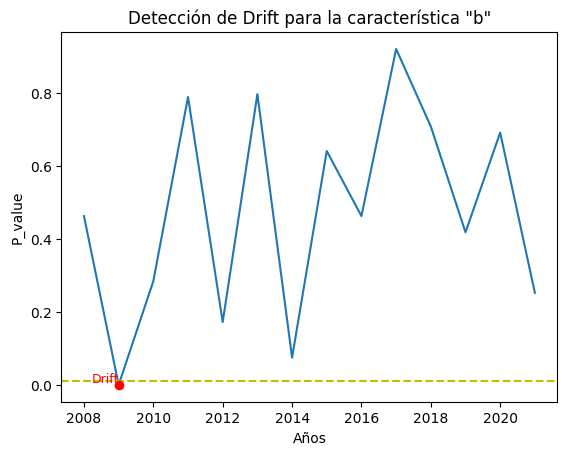

FEATURE  c


No se detectó drift en el año 2008 con un p-valor de 0.7971707956944961
No se detectó drift en el año 2009 con un p-valor de 0.01144978832332473
No se detectó drift en el año 2010 con un p-valor de 0.7894417405334453
No se detectó drift en el año 2011 con un p-valor de 0.17642045644397497
Drift detectado en el año 2012 con un p-valor de 1.908307785564089e-23
No se detectó drift en el año 2013 con un p-valor de 0.7577488994613479
No se detectó drift en el año 2014 con un p-valor de 0.39043921203312104
No se detectó drift en el año 2015 con un p-valor de 0.3441366262270228
No se detectó drift en el año 2016 con un p-valor de 0.21867463645335583
No se detectó drift en el año 2017 con un p-valor de 0.24250533125905238
No se detectó drift en el año 2018 con un p-valor de 0.2958585904430009
No se detectó drift en el año 2019 con un p-valor de 0.7894417405334433
No se detectó drift en el año 2020 con un p-valor de 0.9106358685130489
No se detectó drift en el año 2021 con un p-val

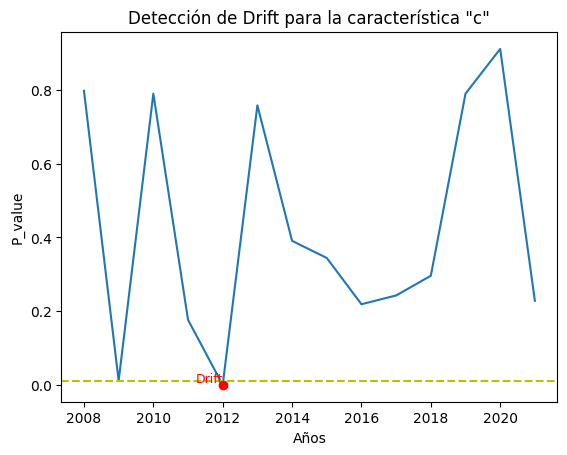

FEATURE  d


No se detectó drift en el año 2008 con un p-valor de 0.7250736496496843
No se detectó drift en el año 2009 con un p-valor de 0.6580885914475068
No se detectó drift en el año 2010 con un p-valor de 0.2525621151128157
No se detectó drift en el año 2011 con un p-valor de 0.8271448115765141
Drift detectado en el año 2012 con un p-valor de 0.0
No se detectó drift en el año 2013 con un p-valor de 0.81980368665157
No se detectó drift en el año 2014 con un p-valor de 0.9690338450377974
No se detectó drift en el año 2015 con un p-valor de 0.41140741652608204
No se detectó drift en el año 2016 con un p-valor de 0.21412962159644366
No se detectó drift en el año 2017 con un p-valor de 0.8484821982318688
No se detectó drift en el año 2018 con un p-valor de 0.9933069892377484
No se detectó drift en el año 2019 con un p-valor de 0.27904204582520264
No se detectó drift en el año 2020 con un p-valor de 0.525292361393908
No se detectó drift en el año 2021 con un p-valor de 0.781629526339975

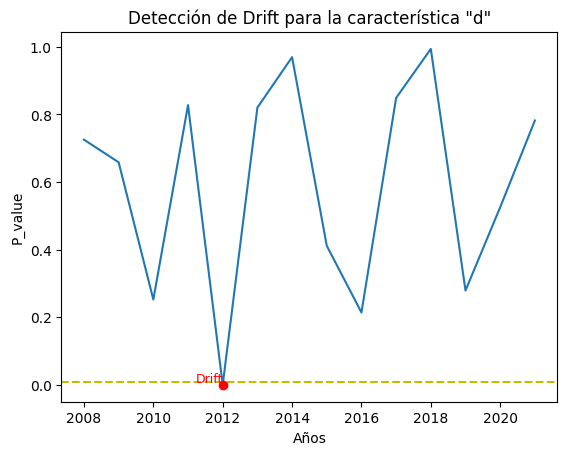

FEATURE  e


No se detectó drift en el año 2008 con un p-valor de 0.8553481838065051
No se detectó drift en el año 2009 con un p-valor de 0.8343752056635089
No se detectó drift en el año 2010 con un p-valor de 0.4043450231304484
No se detectó drift en el año 2011 con un p-valor de 0.24250533125905238
No se detectó drift en el año 2012 con un p-valor de 0.12540506442765476
No se detectó drift en el año 2013 con un p-valor de 0.7415127668764392
No se detectó drift en el año 2014 con un p-valor de 0.8484821982318688
No se detectó drift en el año 2015 con un p-valor de 0.9718457089907019
No se detectó drift en el año 2016 con un p-valor de 0.3254470896952514
No se detectó drift en el año 2017 con un p-valor de 0.7577488994613535
No se detectó drift en el año 2018 con un p-valor de 0.7657776425319498
No se detectó drift en el año 2019 con un p-valor de 0.834375205663501
No se detectó drift en el año 2020 con un p-valor de 0.5825398041918299
No se detectó drift en el año 2021 con un p-valor 

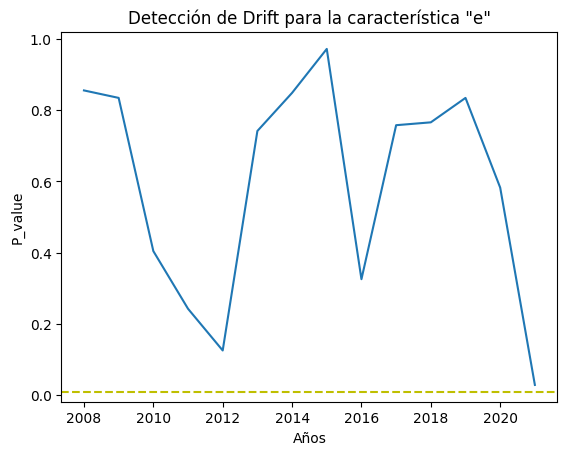

FEATURE  f


No se detectó drift en el año 2008 con un p-valor de 0.1314176298026175
No se detectó drift en el año 2009 con un p-valor de 0.21867463645335317
No se detectó drift en el año 2010 con un p-valor de 0.5992071991851569
No se detectó drift en el año 2011 con un p-valor de 0.8123573009812283
No se detectó drift en el año 2012 con un p-valor de 0.8271448115765141
No se detectó drift en el año 2013 con un p-valor de 0.41140741652608204
No se detectó drift en el año 2014 con un p-valor de 0.4935911029958554
No se detectó drift en el año 2015 con un p-valor de 0.5414432241521083
No se detectó drift en el año 2016 con un p-valor de 0.9106358685130368
No se detectó drift en el año 2017 con un p-valor de 0.7577488994613568
No se detectó drift en el año 2018 con un p-valor de 0.6580885914474974
No se detectó drift en el año 2019 con un p-valor de 0.525292361393908
No se detectó drift en el año 2020 con un p-valor de 0.3635231328593458
No se detectó drift en el año 2021 con un p-valor 

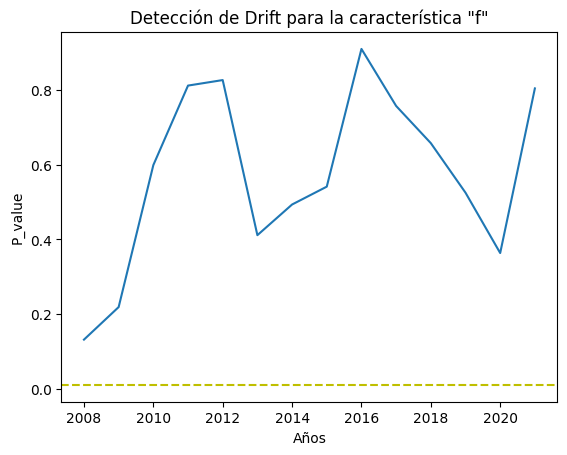

FEATURE  g


No se detectó drift en el año 2008 con un p-valor de 0.5908602093244725
No se detectó drift en el año 2009 con un p-valor de 0.30162000901228003
No se detectó drift en el año 2010 con un p-valor de 0.33159910109593727
No se detectó drift en el año 2011 con un p-valor de 0.7496588296953648
No se detectó drift en el año 2012 con un p-valor de 0.624374156981675
No se detectó drift en el año 2013 con un p-valor de 0.7894417405334346
No se detectó drift en el año 2014 con un p-valor de 0.8876007771287877
No se detectó drift en el año 2015 con un p-valor de 0.8414894509932235
No se detectó drift en el año 2016 con un p-valor de 0.47040522912456817
No se detectó drift en el año 2017 con un p-valor de 0.7577488994613479
No se detectó drift en el año 2018 con un p-valor de 0.8123573009812116
No se detectó drift en el año 2019 con un p-valor de 0.7001240704240935
No se detectó drift en el año 2020 con un p-valor de 0.34413662622701924
No se detectó drift en el año 2021 con un p-valo

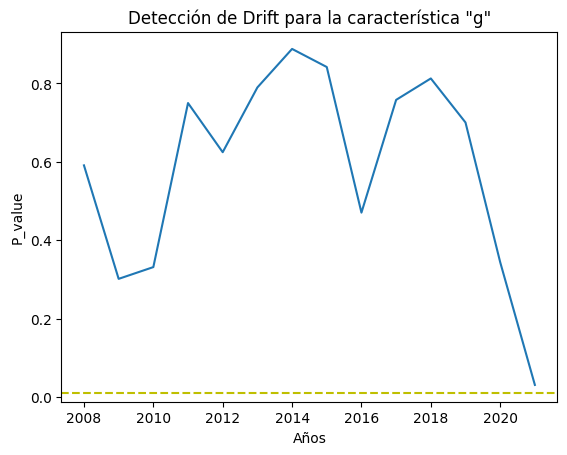

FEATURE  h


No se detectó drift en el año 2008 con un p-valor de 0.5414432241521083
No se detectó drift en el año 2009 con un p-valor de 0.8936027987210781
No se detectó drift en el año 2010 con un p-valor de 0.5992071991851545
No se detectó drift en el año 2011 con un p-valor de 0.8271448115765061
No se detectó drift en el año 2012 con un p-valor de 0.7001240704240935
No se detectó drift en el año 2013 con un p-valor de 0.8343752056635089
No se detectó drift en el año 2014 con un p-valor de 0.7657776425319498
No se detectó drift en el año 2015 con un p-valor de 0.6412214445864826
No se detectó drift en el año 2016 con un p-valor de 0.7737396658858053
No se detectó drift en el año 2017 con un p-valor de 0.7415127668764392
No se detectó drift en el año 2018 con un p-valor de 0.18431410110564717
Drift detectado en el año 2019 con un p-valor de 0.0
Drift detectado en el año 2020 con un p-valor de 0.0
Drift detectado en el año 2021 con un p-valor de 0.0


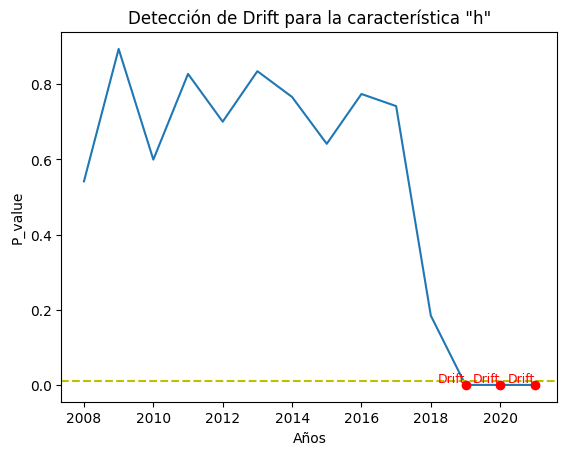

FEATURE  i


No se detectó drift en el año 2008 con un p-valor de 0.7084727253164128
No se detectó drift en el año 2009 con un p-valor de 0.8553481838065051
No se detectó drift en el año 2010 con un p-valor de 0.5014359645922872
No se detectó drift en el año 2011 con un p-valor de 0.7415127668764392
No se detectó drift en el año 2012 con un p-valor de 0.9884274340183611
No se detectó drift en el año 2013 con un p-valor de 0.8876007771287776
No se detectó drift en el año 2014 con un p-valor de 0.9933069892377484
No se detectó drift en el año 2015 con un p-valor de 0.7737396658858053
No se detectó drift en el año 2016 con un p-valor de 0.1843141011056384
No se detectó drift en el año 2017 con un p-valor de 0.3701387077974375
No se detectó drift en el año 2018 con un p-valor de 0.6917497522123475
No se detectó drift en el año 2019 con un p-valor de 0.9595291719586295
No se detectó drift en el año 2020 con un p-valor de 0.41140741652608204
No se detectó drift en el año 2021 con un p-valor 

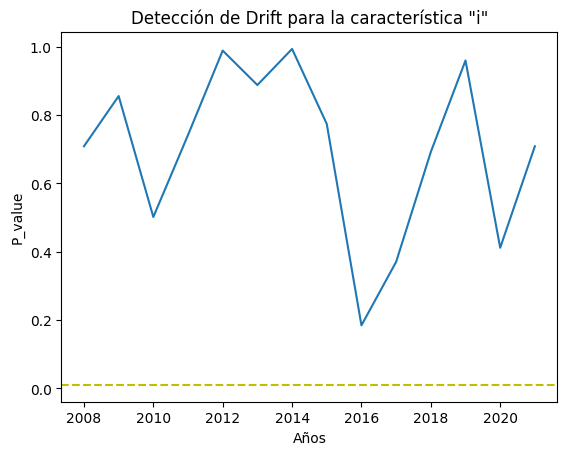

FEATURE  j


No se detectó drift en el año 2008 con un p-valor de 0.37013870779743374
No se detectó drift en el año 2009 con un p-valor de 0.19248149881260113
No se detectó drift en el año 2010 con un p-valor de 0.22329270675463786
No se detectó drift en el año 2011 con un p-valor de 0.19248149881259913
No se detectó drift en el año 2012 con un p-valor de 0.18033337614341305
No se detectó drift en el año 2013 con un p-valor de 0.6243741569816843
No se detectó drift en el año 2014 con un p-valor de 0.30162000901228336
No se detectó drift en el año 2015 con un p-valor de 0.3635231328593421
Drift detectado en el año 2016 con un p-valor de 0.00417396600512519
No se detectó drift en el año 2017 con un p-valor de 0.632793350220073
No se detectó drift en el año 2018 con un p-valor de 0.41140741652608204
No se detectó drift en el año 2019 con un p-valor de 0.2525621151128128
No se detectó drift en el año 2020 con un p-valor de 0.11135257403749343
Drift detectado en el año 2021 con un p-valor d

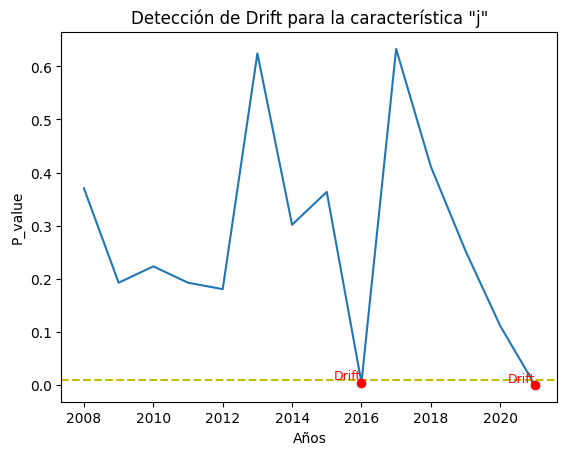

In [10]:
year = np.array(range(2008,2022))
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
values_df = pd.DataFrame(columns = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])


for feat in range(len(features)):
    ks_detector = KSTest()
    _ = ks_detector.fit(X=np.array(X_ref.iloc[:,feat]))

    print('FEATURE ', features[feat])
    print('\n')
    p_values = []
    
    for i, batch in enumerate(batch_generator(np.array(X_t0.iloc[:,feat]), 20000)):
        drift_detection = ks_detector.compare(batch)
        p_values.append(drift_detection[0].p_value)
    
        if drift_detection[0].p_value  < 0.01:
            print(f"Drift detectado en el año {year[i]} con un p-valor de {drift_detection[0].p_value}")
        else:
            print(f"No se detectó drift en el año {year[i]} con un p-valor de {drift_detection[0].p_value}")
    values_df[features[feat]] = p_values
    plot_drift_detection(year, p_values, features[feat])

In [11]:
heatmap_data = values_df.transpose()

In [12]:
heatmap_data.columns = year

In [13]:
heatmap_data

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
a,0.425747,0.666519,0.725074,0.390439,3.701387e-01,0.797171,0.200928,0.599207,0.683354,0.624374,0.893603,0.093886,0.848482,0.765778
b,0.462799,0.000000,0.284570,0.789442,1.725747e-01,0.797171,0.074849,0.641221,0.462799,0.921145,0.708473,0.418542,0.691750,0.252562
c,0.797171,0.011450,0.789442,0.176420,1.908308e-23,0.757749,0.390439,0.344137,0.218675,0.242505,0.295859,0.789442,0.910636,0.227984
d,0.725074,0.658089,0.252562,0.827145,0.000000e+00,0.819804,0.969034,0.411407,0.214130,0.848482,0.993307,0.279042,0.525292,0.781630
e,0.855348,0.834375,0.404345,0.242505,1.254051e-01,0.741513,0.848482,0.971846,0.325447,0.757749,0.765778,0.834375,0.582540,0.028704
f,0.131418,0.218675,0.599207,0.812357,8.271448e-01,0.411407,0.493591,0.541443,0.910636,0.757749,0.658089,0.525292,0.363523,0.804811
g,0.590860,0.301620,0.331599,0.749659,6.243742e-01,0.789442,0.887601,0.841489,0.470405,0.757749,0.812357,0.700124,0.344137,0.031312
h,0.541443,0.893603,0.599207,0.827145,7.001241e-01,0.834375,0.765778,0.641221,0.773740,0.741513,0.184314,0.000000,0.000000,0.000000
i,0.708473,0.855348,0.501436,0.741513,9.884274e-01,0.887601,0.993307,0.773740,0.184314,0.370139,0.691750,0.959529,0.411407,0.708473
j,0.370139,0.192481,0.223293,0.192481,1.803334e-01,0.624374,0.301620,0.363523,0.004174,0.632793,0.411407,0.252562,0.111353,0.000000


In [14]:
sns.set(rc={"figure.figsize": (15, 8)})

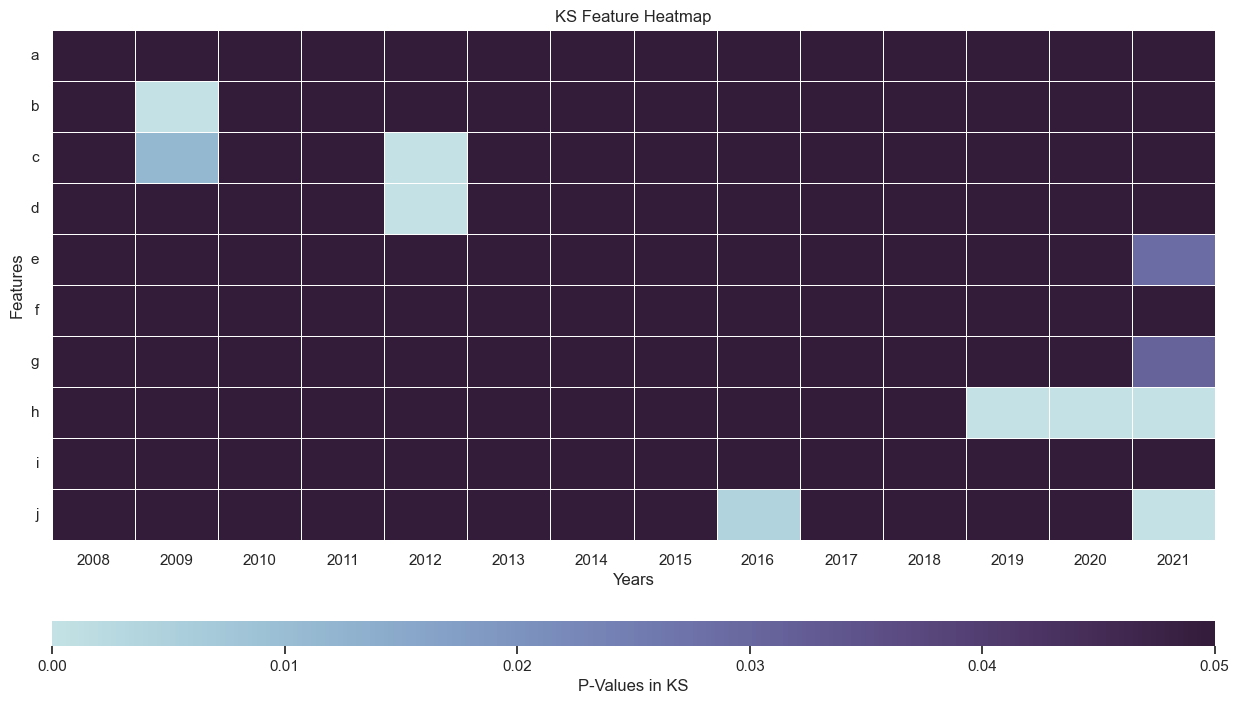

In [15]:
# Setup plot
grid_kws = {"height_ratios": (20, 1), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start = 0.5, rot = -0.4, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    vmax = 0.05,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)

ax.set_title('KS Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("P-Values in KS")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

### CVM

In [16]:
from frouros.detectors.data_drift import CVMTest

No se detectó drift en el año 2008 con un p-valor de 0.5849405616933043
No se detectó drift en el año 2009 con un p-valor de 0.48784752202036097
No se detectó drift en el año 2010 con un p-valor de 0.6100799739479055
No se detectó drift en el año 2011 con un p-valor de 0.20045803825586006
No se detectó drift en el año 2012 con un p-valor de 0.5266528011460088
No se detectó drift en el año 2013 con un p-valor de 0.7442212972754761
No se detectó drift en el año 2014 con un p-valor de 0.40900523887095297
No se detectó drift en el año 2015 con un p-valor de 0.6490666716326812
No se detectó drift en el año 2016 con un p-valor de 0.7059650115771956
No se detectó drift en el año 2017 con un p-valor de 0.6270014860949576
No se detectó drift en el año 2018 con un p-valor de 0.8494572338606508
No se detectó drift en el año 2019 con un p-valor de 0.028360653296392146
No se detectó drift en el año 2020 con un p-valor de 0.66646567931214
No se detectó drift en el año 2021 con un p-valor de 0.708800

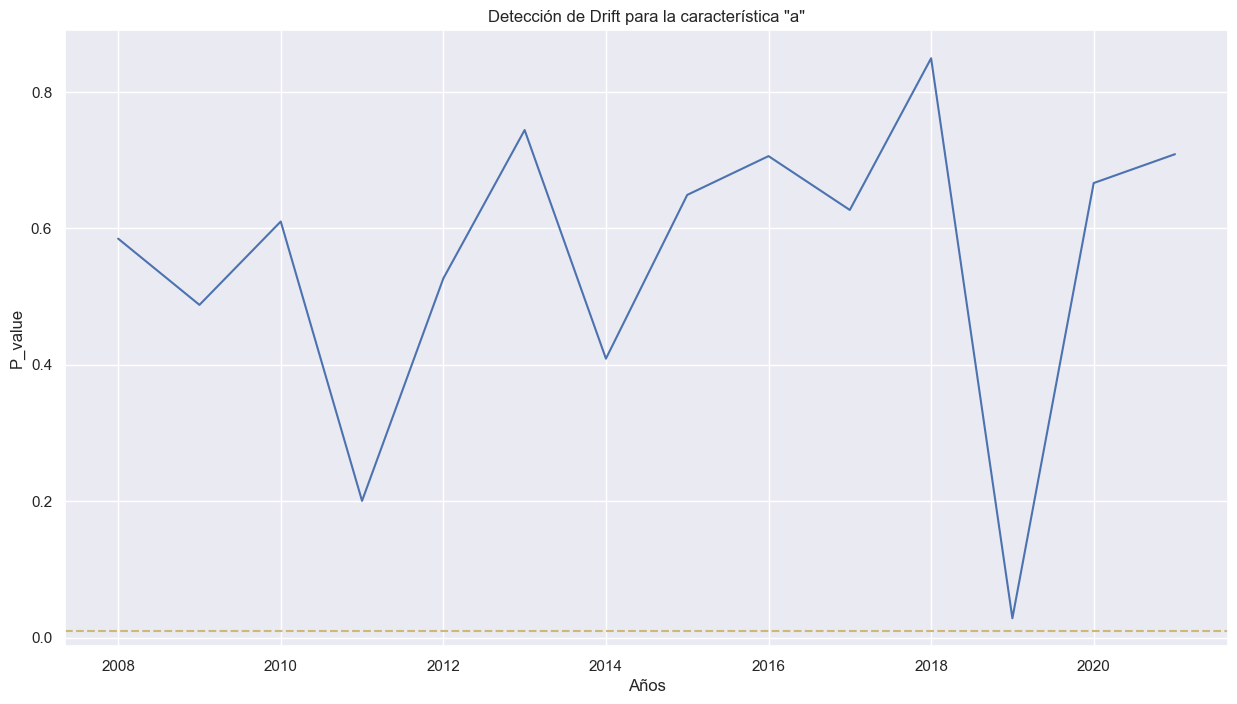

No se detectó drift en el año 2008 con un p-valor de 0.368787921294341
Drift detectado en el año 2009 con un p-valor de 4.927452568193047e-07
No se detectó drift en el año 2010 con un p-valor de 0.5030134654102615
No se detectó drift en el año 2011 con un p-valor de 0.9247171766845507
No se detectó drift en el año 2012 con un p-valor de 0.14762954421299612
No se detectó drift en el año 2013 con un p-valor de 0.5513002536235477
No se detectó drift en el año 2014 con un p-valor de 0.11063375628099859
No se detectó drift en el año 2015 con un p-valor de 0.4486179734619006
No se detectó drift en el año 2016 con un p-valor de 0.296466625887048
No se detectó drift en el año 2017 con un p-valor de 0.959242933228527
No se detectó drift en el año 2018 con un p-valor de 0.8613834681984354
No se detectó drift en el año 2019 con un p-valor de 0.23973592557166057
No se detectó drift en el año 2020 con un p-valor de 0.8090465824798158
No se detectó drift en el año 2021 con un p-valor de 0.2263603890

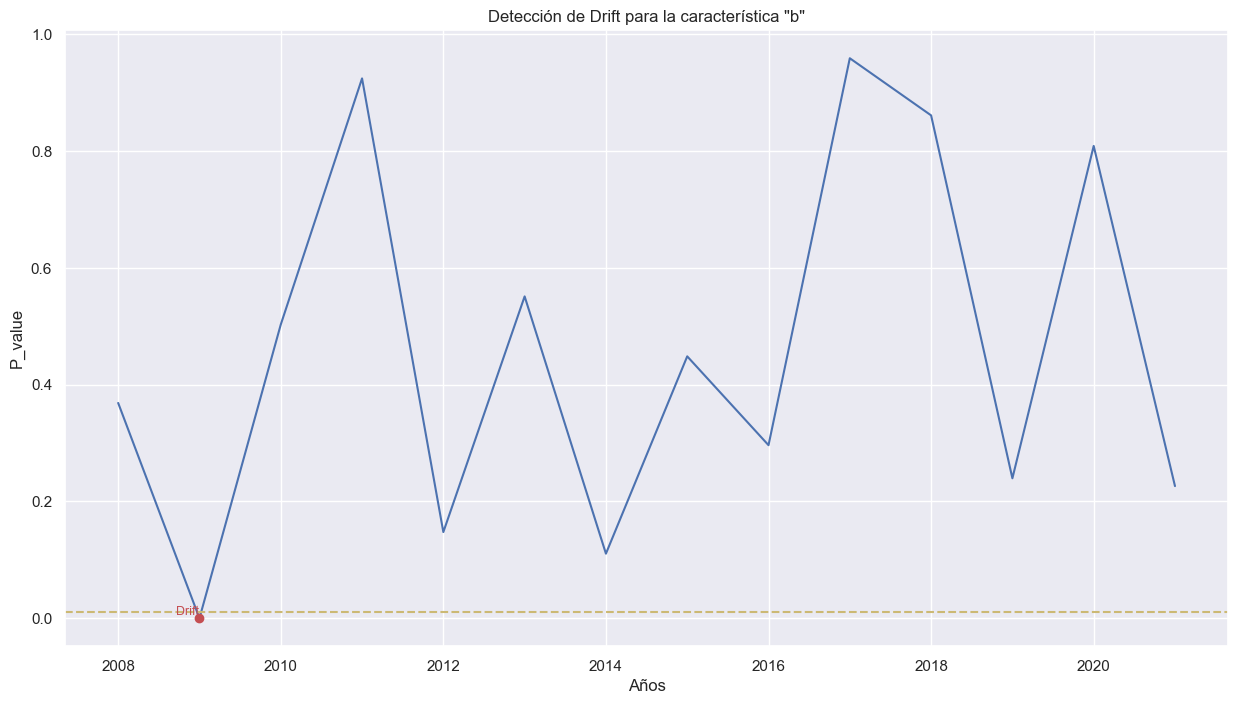

No se detectó drift en el año 2008 con un p-valor de 0.7799542509969302
No se detectó drift en el año 2009 con un p-valor de 0.020592887518414593
No se detectó drift en el año 2010 con un p-valor de 0.9713806037753702
No se detectó drift en el año 2011 con un p-valor de 0.23369991643673937
Drift detectado en el año 2012 con un p-valor de 6.086969817076238e-10
No se detectó drift en el año 2013 con un p-valor de 0.5858531029056628
No se detectó drift en el año 2014 con un p-valor de 0.3373783752053522
No se detectó drift en el año 2015 con un p-valor de 0.18438569918090486
No se detectó drift en el año 2016 con un p-valor de 0.18446326970055538
No se detectó drift en el año 2017 con un p-valor de 0.4316043702812833
No se detectó drift en el año 2018 con un p-valor de 0.2990550742306268
No se detectó drift en el año 2019 con un p-valor de 0.6269872975141539
No se detectó drift en el año 2020 con un p-valor de 0.8711970155605325
No se detectó drift en el año 2021 con un p-valor de 0.37959

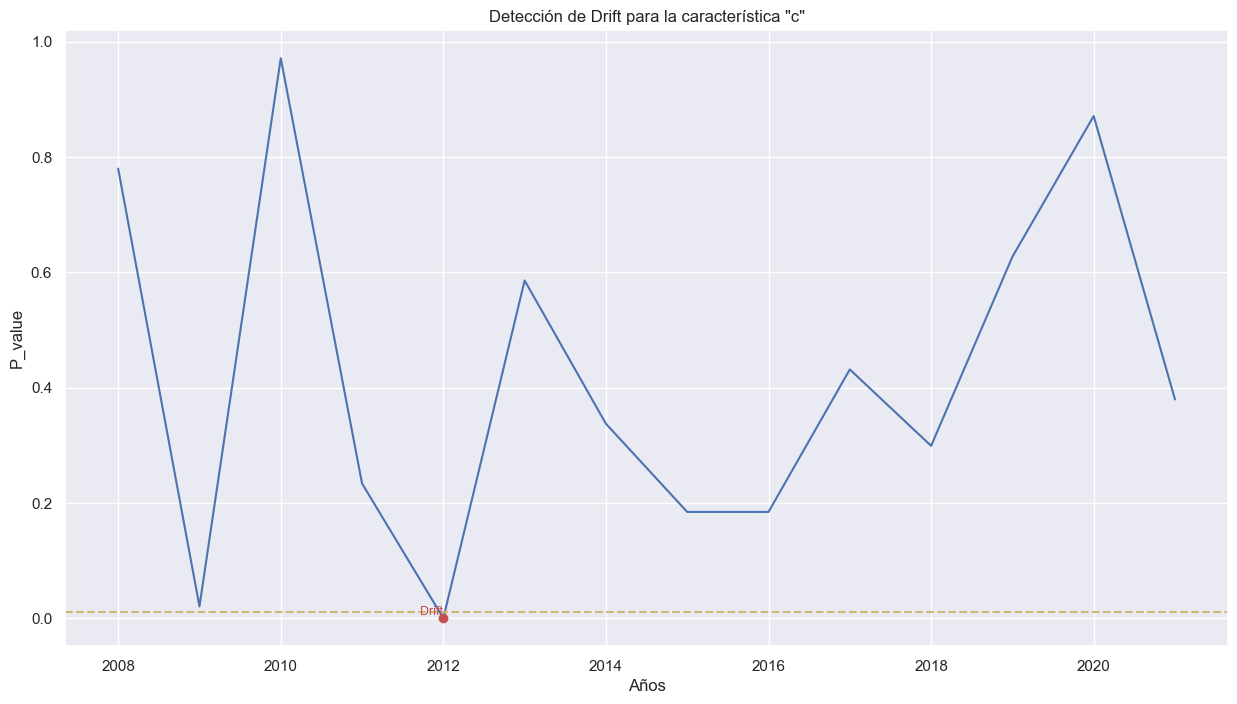

No se detectó drift en el año 2008 con un p-valor de 0.865095188239208
No se detectó drift en el año 2009 con un p-valor de 0.6848947655539293
No se detectó drift en el año 2010 con un p-valor de 0.2368035096156359
No se detectó drift en el año 2011 con un p-valor de 0.864793550699196
Drift detectado en el año 2012 con un p-valor de 8.849059296434092e-08
No se detectó drift en el año 2013 con un p-valor de 0.914276843118759
No se detectó drift en el año 2014 con un p-valor de 0.9578284875351577
No se detectó drift en el año 2015 con un p-valor de 0.550839451934116
No se detectó drift en el año 2016 con un p-valor de 0.1382794445092087
No se detectó drift en el año 2017 con un p-valor de 0.8122949767480937
No se detectó drift en el año 2018 con un p-valor de 0.9761041427943167
No se detectó drift en el año 2019 con un p-valor de 0.1439919260328072
No se detectó drift en el año 2020 con un p-valor de 0.6356975499960247
No se detectó drift en el año 2021 con un p-valor de 0.81359171356957

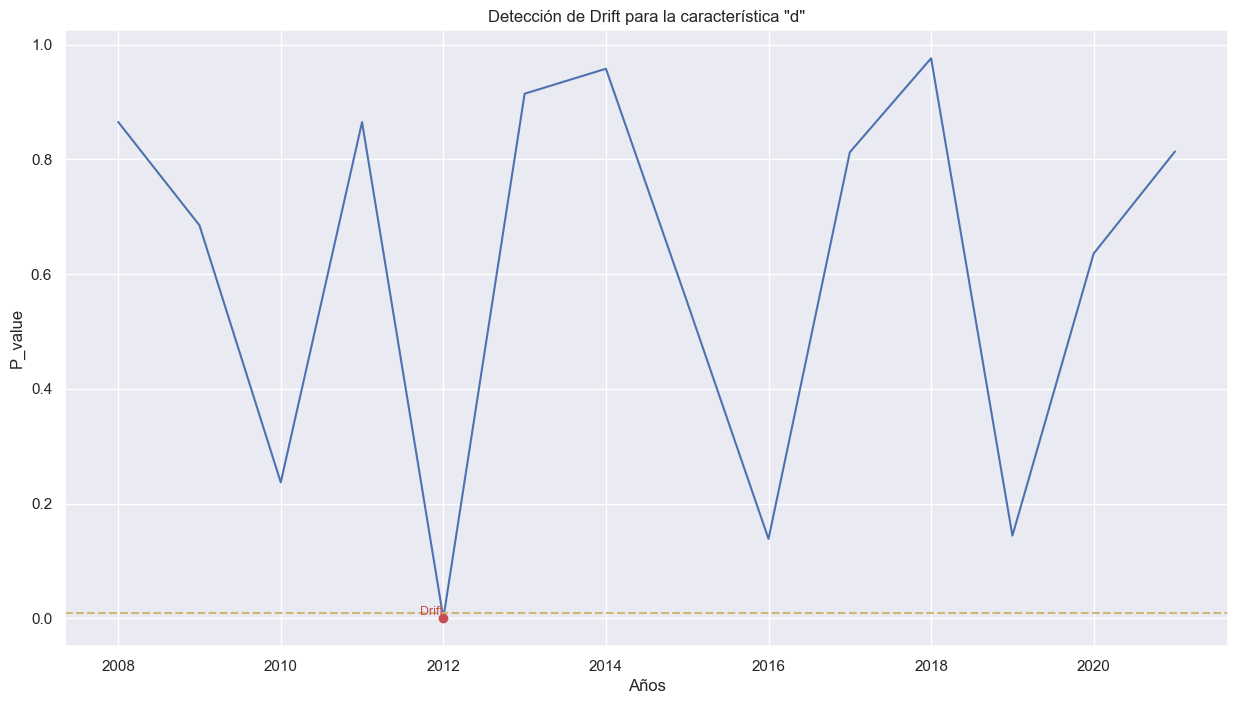

No se detectó drift en el año 2008 con un p-valor de 0.8826241191958711
No se detectó drift en el año 2009 con un p-valor de 0.7671634275884005
No se detectó drift en el año 2010 con un p-valor de 0.5529359221890031
No se detectó drift en el año 2011 con un p-valor de 0.2135291108008942
No se detectó drift en el año 2012 con un p-valor de 0.057361468184577546
No se detectó drift en el año 2013 con un p-valor de 0.82928489974211
No se detectó drift en el año 2014 con un p-valor de 0.7273546634110446
No se detectó drift en el año 2015 con un p-valor de 0.9729239576788767
No se detectó drift en el año 2016 con un p-valor de 0.1348248083095407
No se detectó drift en el año 2017 con un p-valor de 0.8296422709737648
No se detectó drift en el año 2018 con un p-valor de 0.8948799080831935
No se detectó drift en el año 2019 con un p-valor de 0.793664915615401
No se detectó drift en el año 2020 con un p-valor de 0.4040395396092382
No se detectó drift en el año 2021 con un p-valor de 0.0920407225

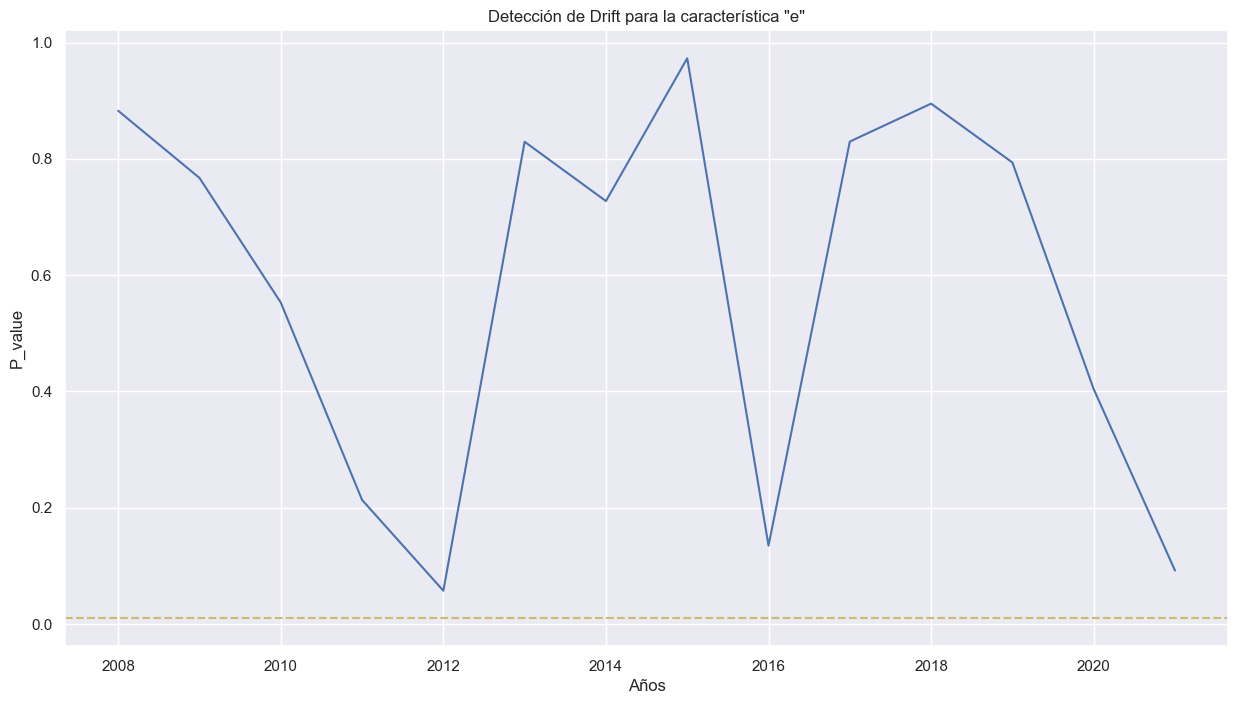

No se detectó drift en el año 2008 con un p-valor de 0.1311227741576727
No se detectó drift en el año 2009 con un p-valor de 0.1844346109832059
No se detectó drift en el año 2010 con un p-valor de 0.47946827330057296
No se detectó drift en el año 2011 con un p-valor de 0.7558651816576805
No se detectó drift en el año 2012 con un p-valor de 0.6931021495488554
No se detectó drift en el año 2013 con un p-valor de 0.39356273471752734
No se detectó drift en el año 2014 con un p-valor de 0.8836746647321133
No se detectó drift en el año 2015 con un p-valor de 0.35439503216073187
No se detectó drift en el año 2016 con un p-valor de 0.9600794106033005
No se detectó drift en el año 2017 con un p-valor de 0.7590335006294824
No se detectó drift en el año 2018 con un p-valor de 0.7477277640624151
No se detectó drift en el año 2019 con un p-valor de 0.511160654525397
No se detectó drift en el año 2020 con un p-valor de 0.4809003445460144
No se detectó drift en el año 2021 con un p-valor de 0.6547924

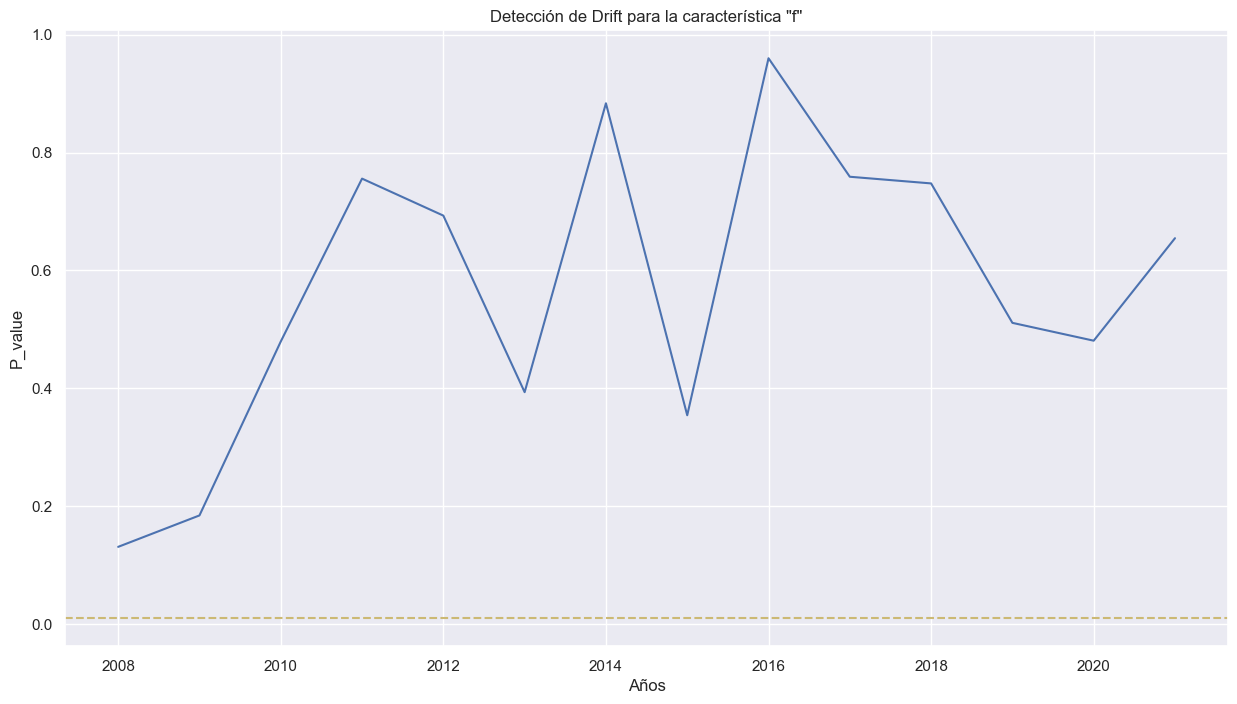

No se detectó drift en el año 2008 con un p-valor de 0.5391324273037682
No se detectó drift en el año 2009 con un p-valor de 0.2442583630058669
No se detectó drift en el año 2010 con un p-valor de 0.28692106190870414
No se detectó drift en el año 2011 con un p-valor de 0.6050242595860439
No se detectó drift en el año 2012 con un p-valor de 0.3778024877121954
No se detectó drift en el año 2013 con un p-valor de 0.6734397357099018
No se detectó drift en el año 2014 con un p-valor de 0.8719515741487162
No se detectó drift en el año 2015 con un p-valor de 0.8390997962432435
No se detectó drift en el año 2016 con un p-valor de 0.42043328555595316
No se detectó drift en el año 2017 con un p-valor de 0.8663127261524525
No se detectó drift en el año 2018 con un p-valor de 0.8276868801739118
No se detectó drift en el año 2019 con un p-valor de 0.6327472364959229
No se detectó drift en el año 2020 con un p-valor de 0.30686555024020756
No se detectó drift en el año 2021 con un p-valor de 0.023920

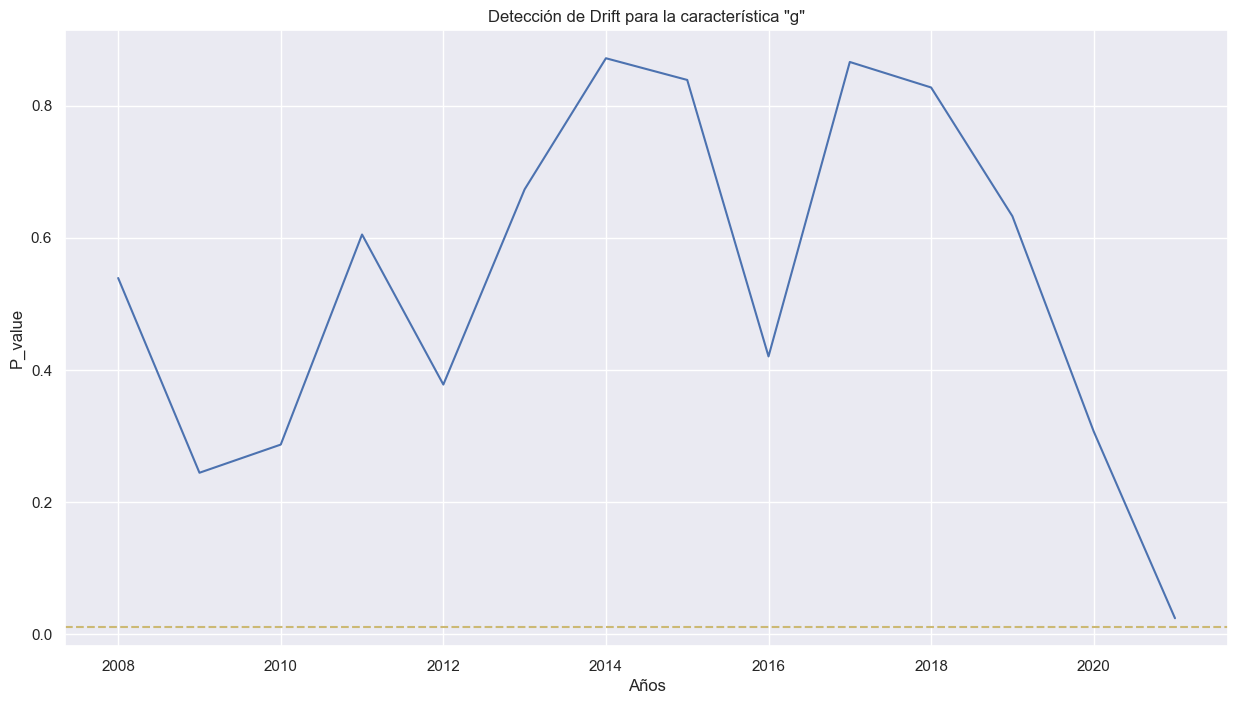

No se detectó drift en el año 2008 con un p-valor de 0.7176064202283152
No se detectó drift en el año 2009 con un p-valor de 0.9359554974673483
No se detectó drift en el año 2010 con un p-valor de 0.6433250870222357
No se detectó drift en el año 2011 con un p-valor de 0.6416895115563397
No se detectó drift en el año 2012 con un p-valor de 0.46367145506631857
No se detectó drift en el año 2013 con un p-valor de 0.6851939021564721
No se detectó drift en el año 2014 con un p-valor de 0.49363662564639577
No se detectó drift en el año 2015 con un p-valor de 0.6536214512106773
No se detectó drift en el año 2016 con un p-valor de 0.8610065868968947
No se detectó drift en el año 2017 con un p-valor de 0.7000038210432173
No se detectó drift en el año 2018 con un p-valor de 0.16862118950139904
Drift detectado en el año 2019 con un p-valor de 4.862051281584456e-07
Drift detectado en el año 2020 con un p-valor de 4.828635845610663e-07
Drift detectado en el año 2021 con un p-valor de 4.851182623388

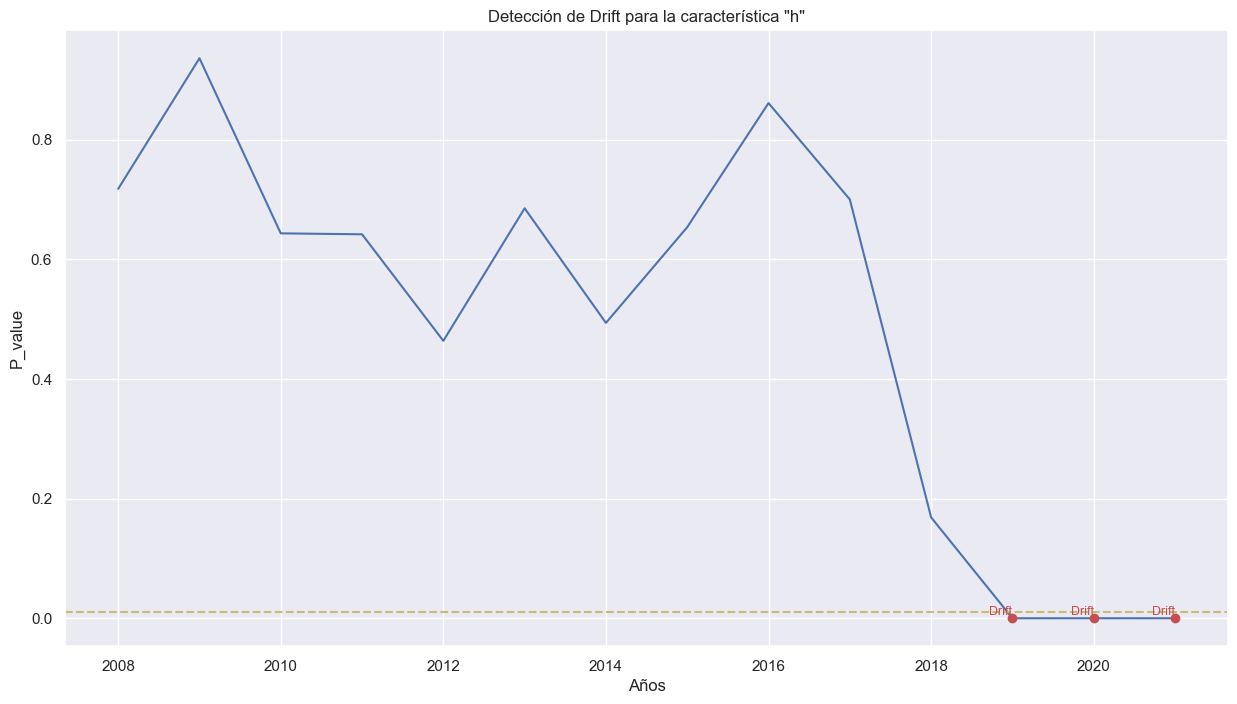

No se detectó drift en el año 2008 con un p-valor de 0.5896468913179918
No se detectó drift en el año 2009 con un p-valor de 0.937236632935551
No se detectó drift en el año 2010 con un p-valor de 0.7438658302614404
No se detectó drift en el año 2011 con un p-valor de 0.5554255601158204
No se detectó drift en el año 2012 con un p-valor de 0.9890854668715698
No se detectó drift en el año 2013 con un p-valor de 0.7766880510720098
No se detectó drift en el año 2014 con un p-valor de 0.9917495007586518
No se detectó drift en el año 2015 con un p-valor de 0.6223078057297993
No se detectó drift en el año 2016 con un p-valor de 0.2391891230547054
No se detectó drift en el año 2017 con un p-valor de 0.2137858542201725
No se detectó drift en el año 2018 con un p-valor de 0.8350990519547928
No se detectó drift en el año 2019 con un p-valor de 0.9224823918578396
No se detectó drift en el año 2020 con un p-valor de 0.75975866062318
No se detectó drift en el año 2021 con un p-valor de 0.619676134472

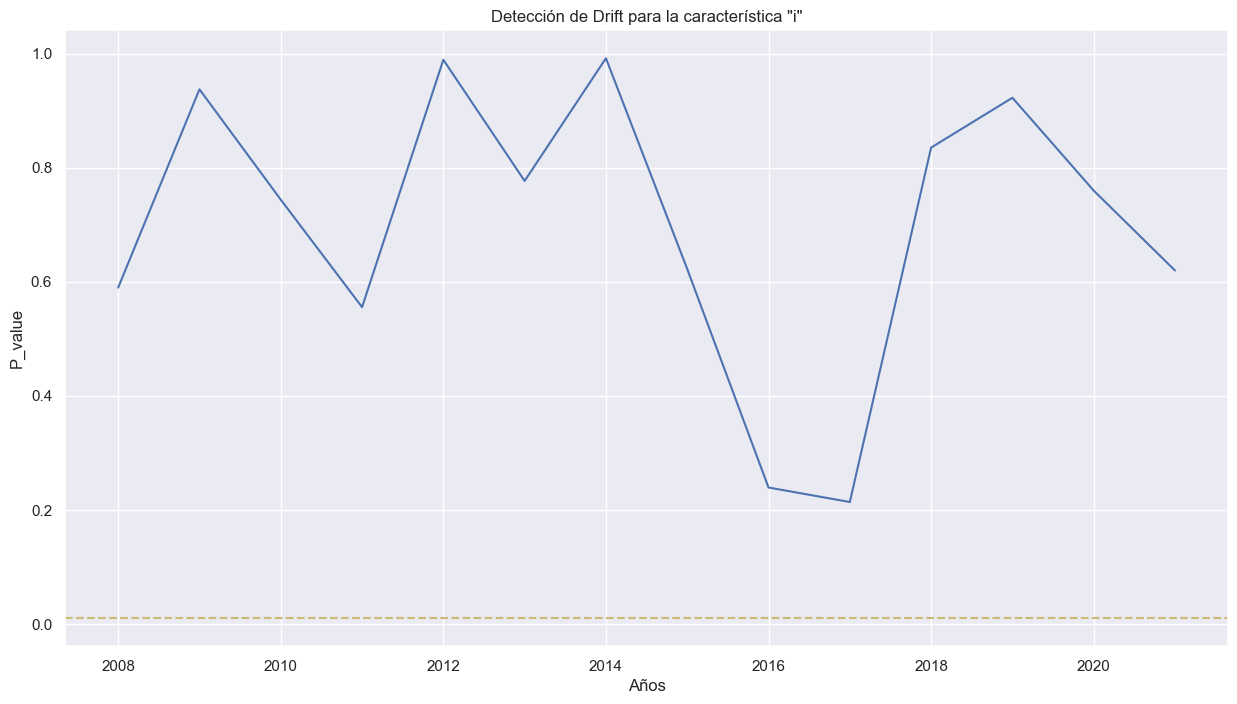

No se detectó drift en el año 2008 con un p-valor de 0.3613254884028091
No se detectó drift en el año 2009 con un p-valor de 0.28190165842859694
No se detectó drift en el año 2010 con un p-valor de 0.2751974670451637
No se detectó drift en el año 2011 con un p-valor de 0.2638412033004378
No se detectó drift en el año 2012 con un p-valor de 0.0691011926361692
No se detectó drift en el año 2013 con un p-valor de 0.5948834288664011
No se detectó drift en el año 2014 con un p-valor de 0.20416775594239722
No se detectó drift en el año 2015 con un p-valor de 0.3339650523219565
Drift detectado en el año 2016 con un p-valor de 0.0034099472968476263
No se detectó drift en el año 2017 con un p-valor de 0.6192590256480037
No se detectó drift en el año 2018 con un p-valor de 0.5775646431499353
No se detectó drift en el año 2019 con un p-valor de 0.272125509393071
No se detectó drift en el año 2020 con un p-valor de 0.1753393445603878
Drift detectado en el año 2021 con un p-valor de 4.9272530266986

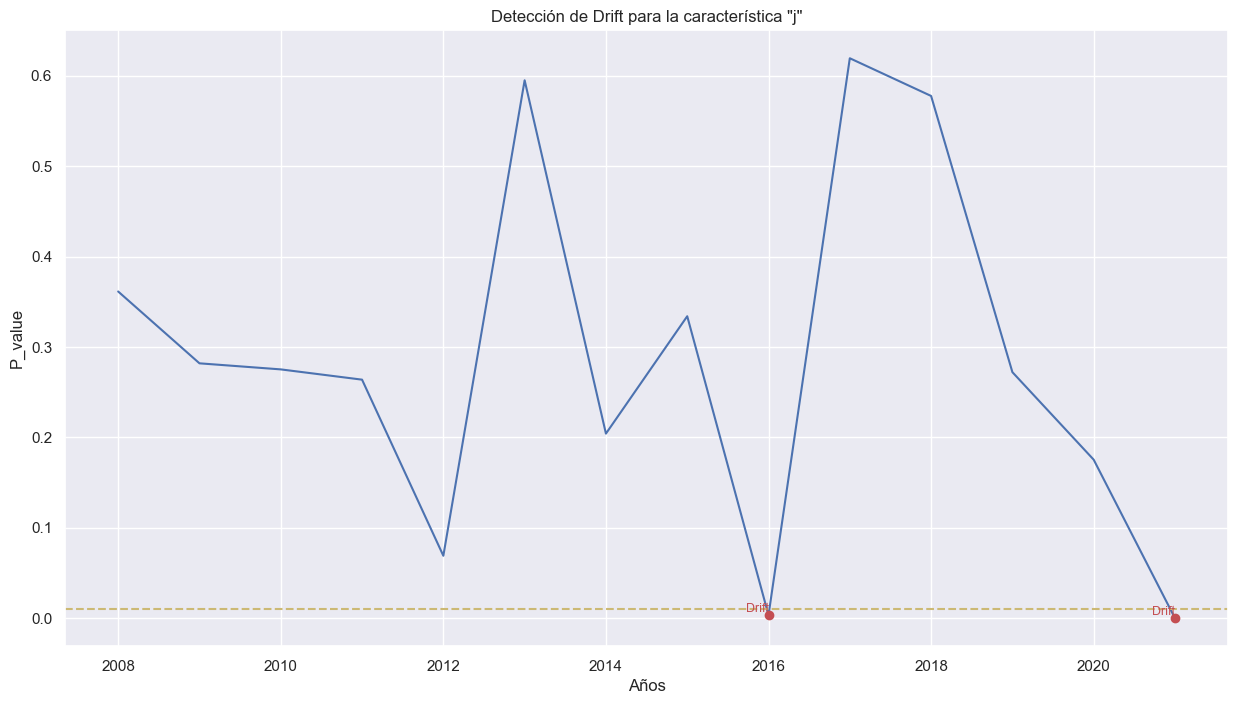

In [17]:
year = np.array(range(2008,2022))
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
values_df = pd.DataFrame(columns = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])

for feat in range(len(features)):
    cvm_detector = CVMTest()
    _ = cvm_detector.fit(X=np.array(X_ref.iloc[:,feat]))
    
    p_values = []
    
    for i, batch in enumerate(batch_generator(np.array(X_t0.iloc[:,feat]), 20000)):
        drift_detection = cvm_detector.compare(batch)
        p_values.append(drift_detection[0].p_value)
    
        if drift_detection[0].p_value  < 0.01:
            print(f"Drift detectado en el año {year[i]} con un p-valor de {drift_detection[0].p_value}")
        else:
            print(f"No se detectó drift en el año {year[i]} con un p-valor de {drift_detection[0].p_value}")
    values_df[features[feat]] = p_values
    plot_drift_detection(year, p_values, features[feat])

In [18]:
heatmap_data = values_df.transpose()

In [19]:
heatmap_data.columns = year

In [20]:
sns.set(rc={"figure.figsize": (15, 8)})

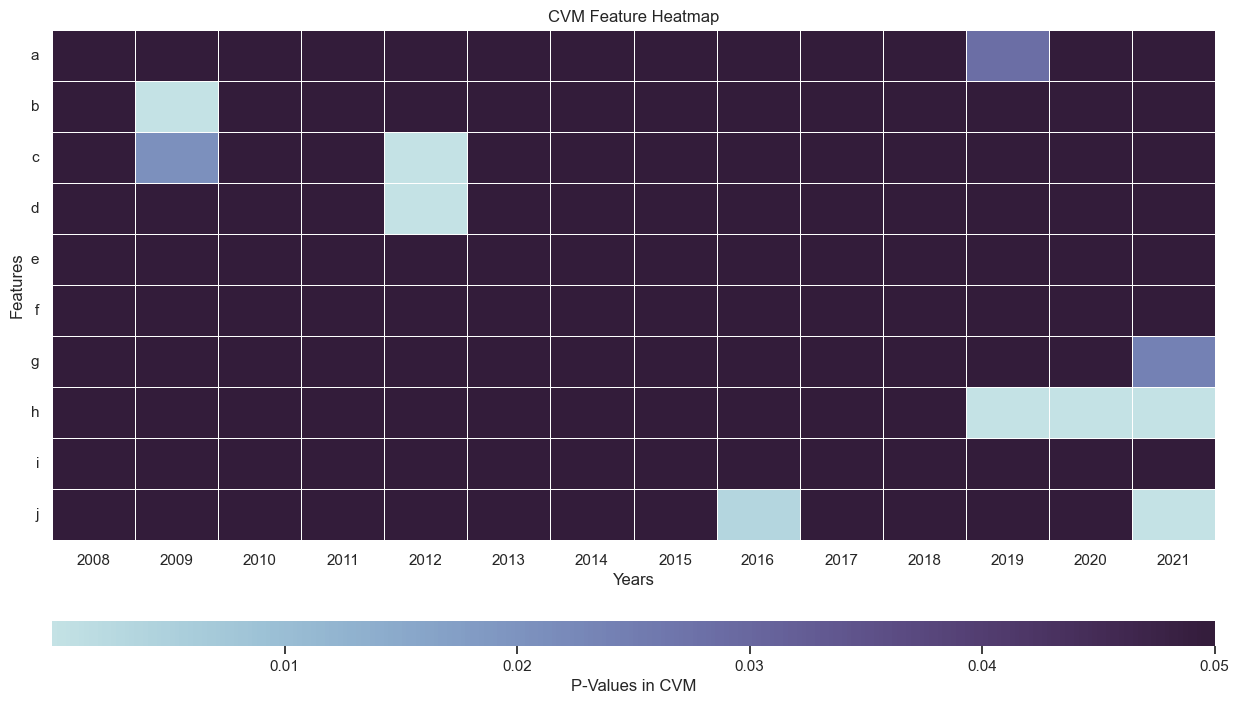

In [21]:
# Setup plot
grid_kws = {"height_ratios": (20, 1), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start = 0.5, rot = -0.4, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    vmax = 0.05,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)

ax.set_title('CVM Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("P-Values in CVM")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

### Anderson Darling Test

In [22]:
from frouros.detectors.data_drift import AndersonDarlingTest

C:\Users\jaizpitarte\AppData\Local\anaconda3\envs\Frouros\Lib\site-packages\frouros\detectors\data_drift\batch\statistical_test\anderson_darling.py:61: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  test = anderson_ksamp(


No se detectó drift en el año 2008 con un p-valor de 0.25
No se detectó drift en el año 2009 con un p-valor de 0.25
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.2411463111971562
No se detectó drift en el año 2012 con un p-valor de 0.25
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.25
No se detectó drift en el año 2015 con un p-valor de 0.25
No se detectó drift en el año 2016 con un p-valor de 0.25
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.25
No se detectó drift en el año 2019 con un p-valor de 0.031567568242474066
No se detectó drift en el año 2020 con un p-valor de 0.25
No se detectó drift en el año 2021 con un p-valor de 0.25


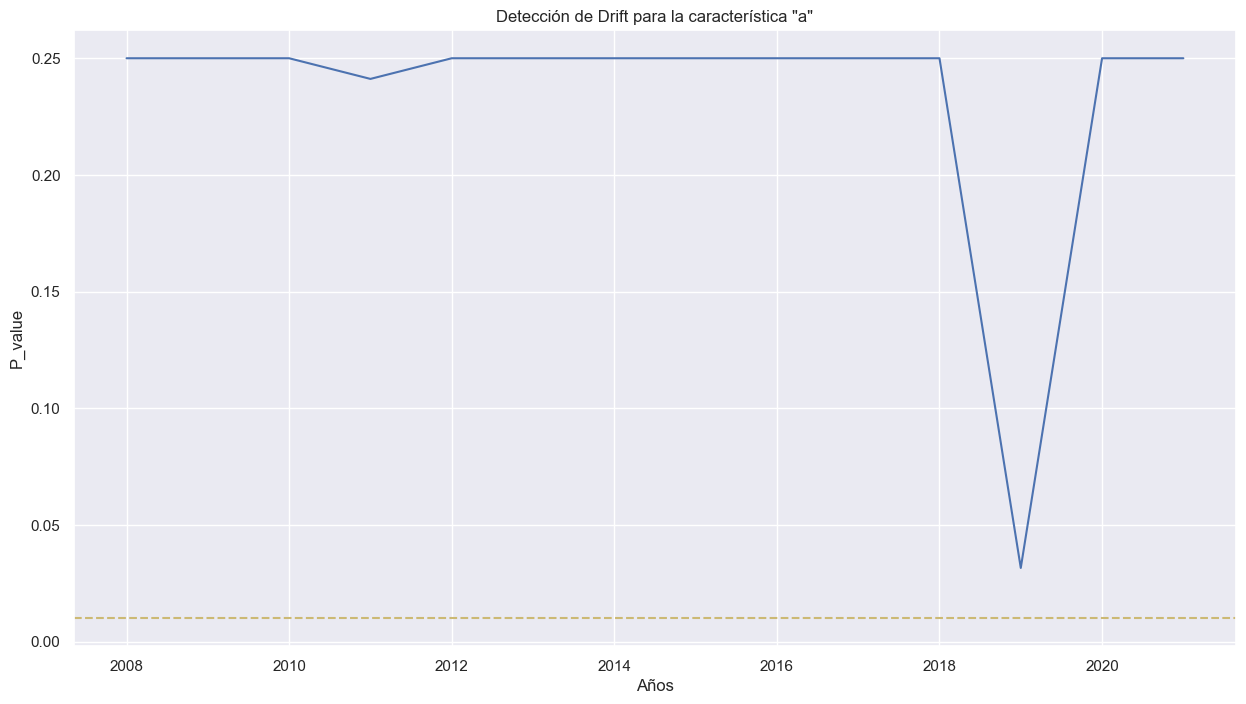

No se detectó drift en el año 2008 con un p-valor de 0.25
Drift detectado en el año 2009 con un p-valor de 0.001
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.25
No se detectó drift en el año 2012 con un p-valor de 0.12143810103339595
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.06893499975531103
No se detectó drift en el año 2015 con un p-valor de 0.25
No se detectó drift en el año 2016 con un p-valor de 0.233891951079236
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.25
No se detectó drift en el año 2019 con un p-valor de 0.23735061902097024
No se detectó drift en el año 2020 con un p-valor de 0.25
No se detectó drift en el año 2021 con un p-valor de 0.2283249411111345


C:\Users\jaizpitarte\AppData\Local\anaconda3\envs\Frouros\Lib\site-packages\frouros\detectors\data_drift\batch\statistical_test\anderson_darling.py:61: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  test = anderson_ksamp(


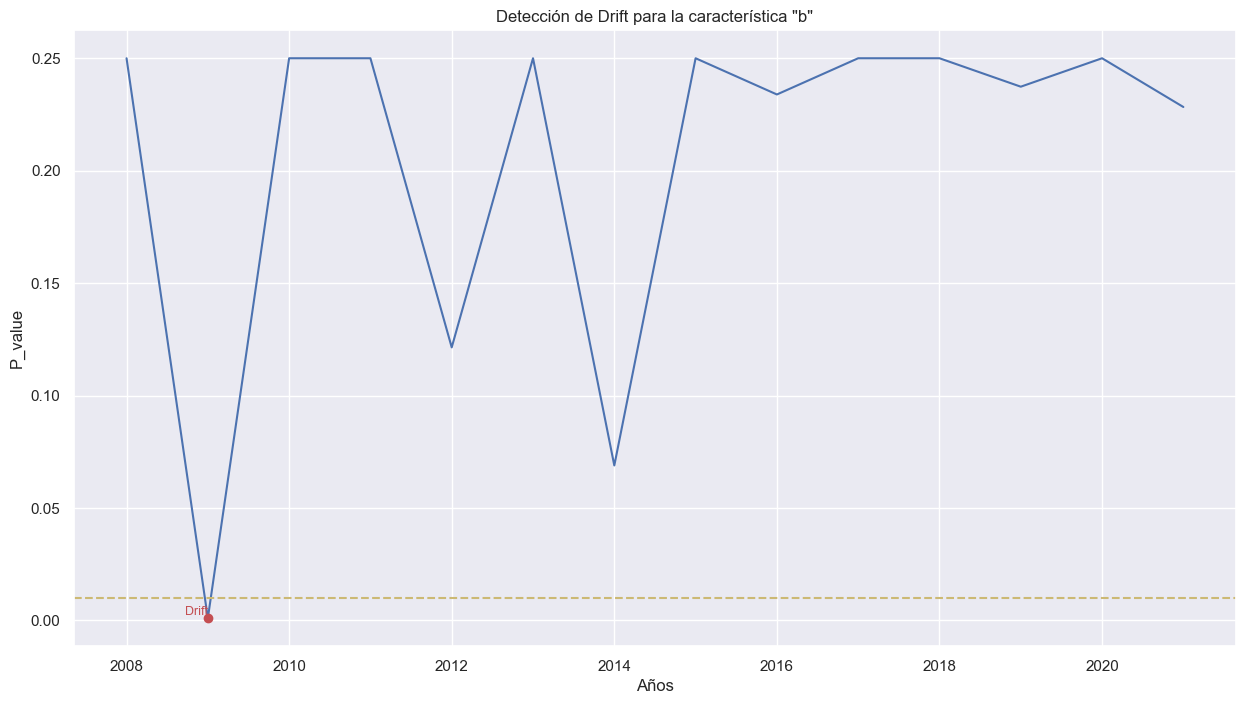

No se detectó drift en el año 2008 con un p-valor de 0.25
No se detectó drift en el año 2009 con un p-valor de 0.01586389855444529
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.25
Drift detectado en el año 2012 con un p-valor de 0.001
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.25
No se detectó drift en el año 2015 con un p-valor de 0.14764648841344755
No se detectó drift en el año 2016 con un p-valor de 0.13886181773632308
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.21491985273662662
No se detectó drift en el año 2019 con un p-valor de 0.25
No se detectó drift en el año 2020 con un p-valor de 0.25
No se detectó drift en el año 2021 con un p-valor de 0.25


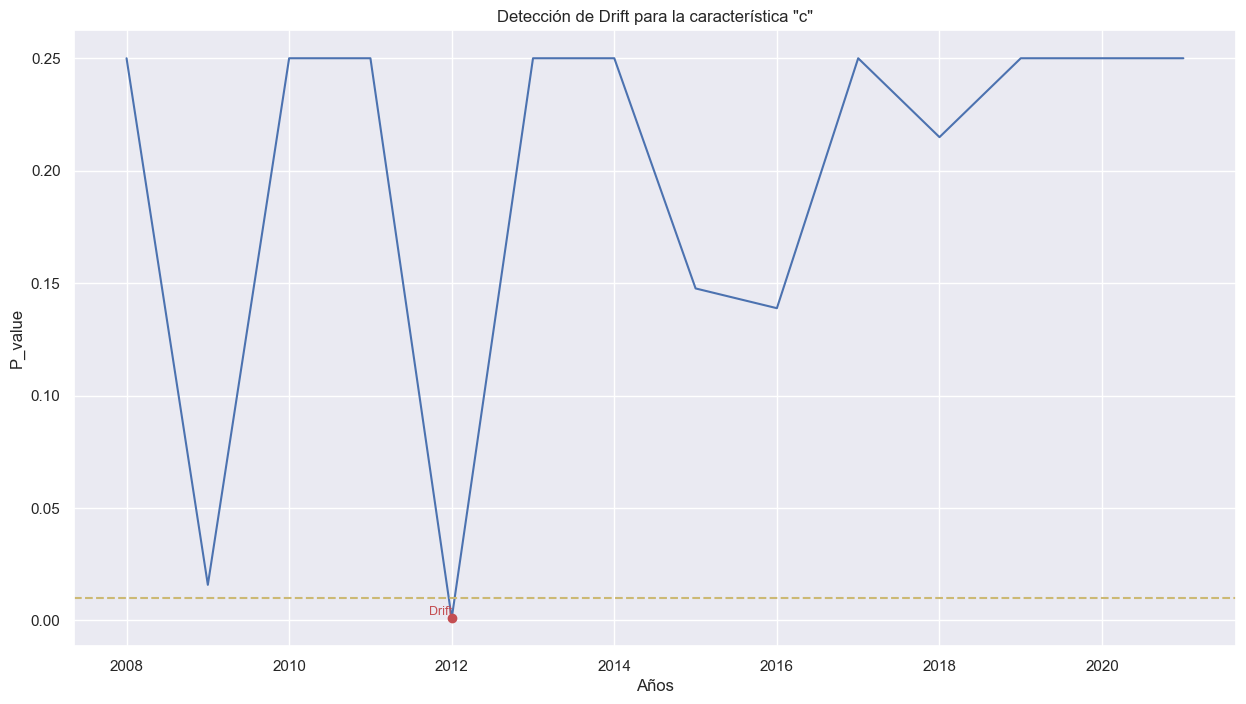

No se detectó drift en el año 2008 con un p-valor de 0.25
No se detectó drift en el año 2009 con un p-valor de 0.25
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.25
Drift detectado en el año 2012 con un p-valor de 0.001
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.25
No se detectó drift en el año 2015 con un p-valor de 0.25
No se detectó drift en el año 2016 con un p-valor de 0.14435847032733964
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.25
No se detectó drift en el año 2019 con un p-valor de 0.1399374846880243
No se detectó drift en el año 2020 con un p-valor de 0.25
No se detectó drift en el año 2021 con un p-valor de 0.25


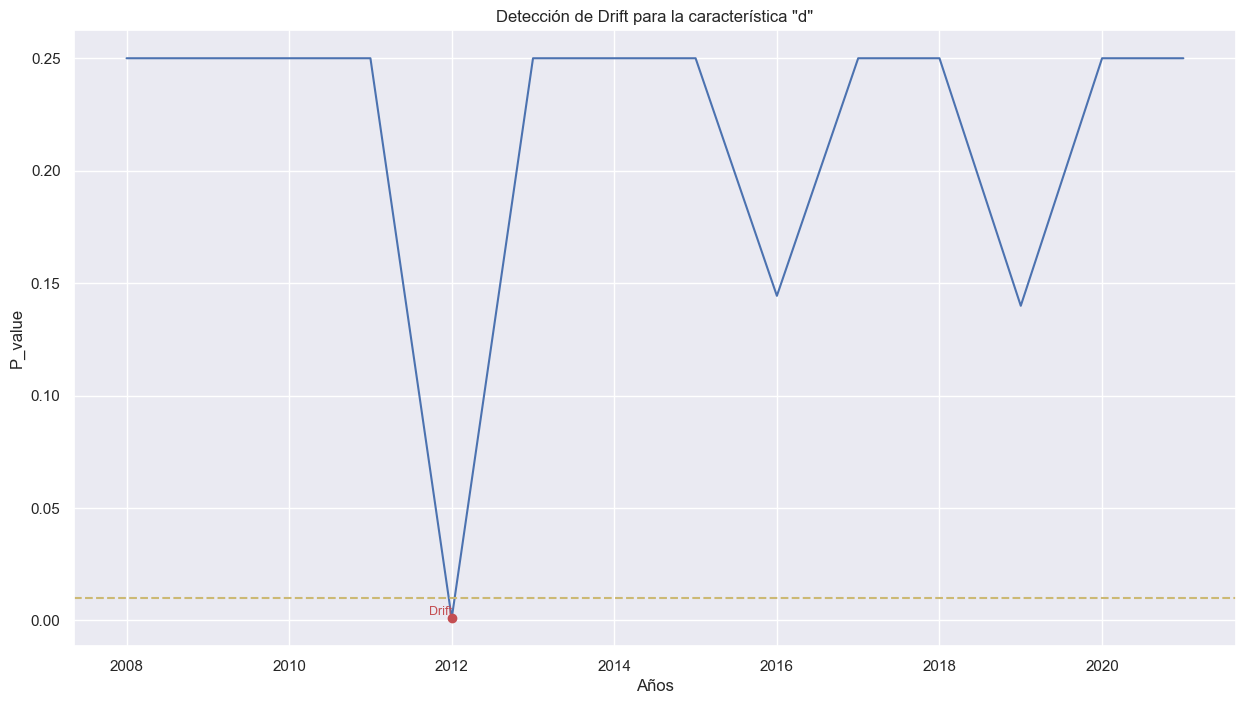

No se detectó drift en el año 2008 con un p-valor de 0.25
No se detectó drift en el año 2009 con un p-valor de 0.25
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.2174907554910263
No se detectó drift en el año 2012 con un p-valor de 0.07092273510985012
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.25
No se detectó drift en el año 2015 con un p-valor de 0.25
No se detectó drift en el año 2016 con un p-valor de 0.10485250024696276
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.25
No se detectó drift en el año 2019 con un p-valor de 0.25
No se detectó drift en el año 2020 con un p-valor de 0.25
No se detectó drift en el año 2021 con un p-valor de 0.1455051498536663


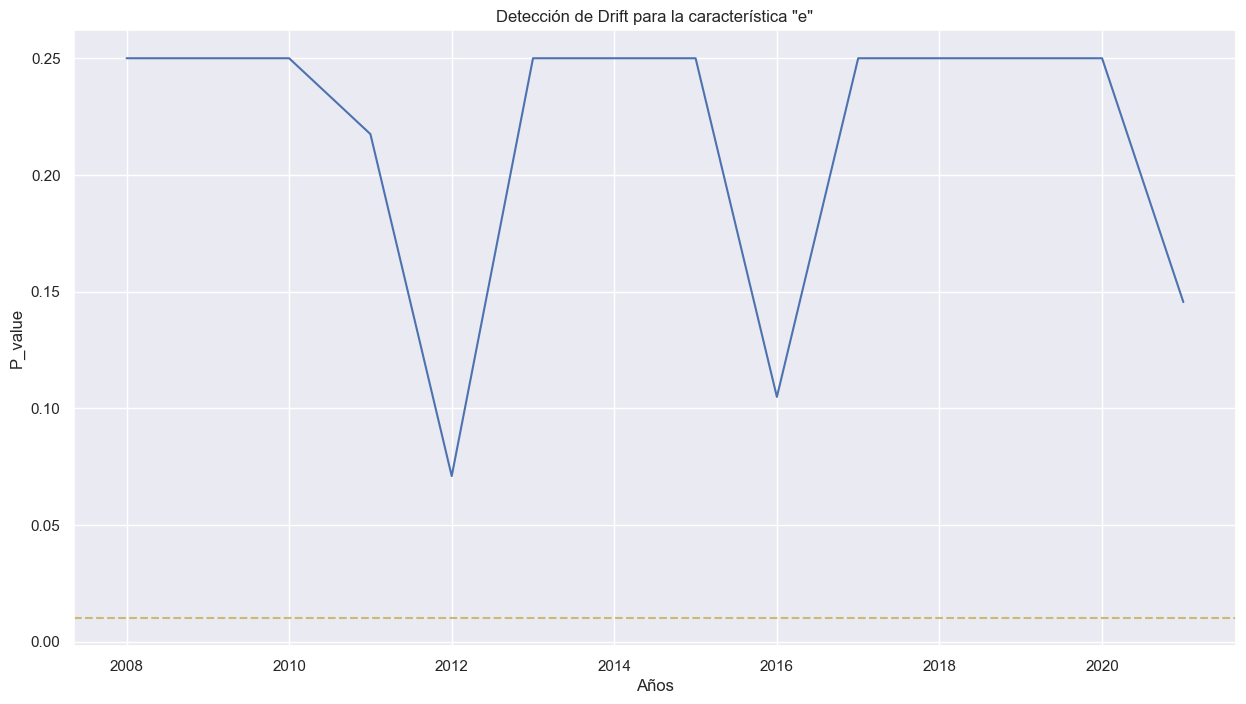

No se detectó drift en el año 2008 con un p-valor de 0.14261025408164252
No se detectó drift en el año 2009 con un p-valor de 0.2191945432118009
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.25
No se detectó drift en el año 2012 con un p-valor de 0.25
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.25
No se detectó drift en el año 2015 con un p-valor de 0.25
No se detectó drift en el año 2016 con un p-valor de 0.25
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.25
No se detectó drift en el año 2019 con un p-valor de 0.25
No se detectó drift en el año 2020 con un p-valor de 0.25
No se detectó drift en el año 2021 con un p-valor de 0.25


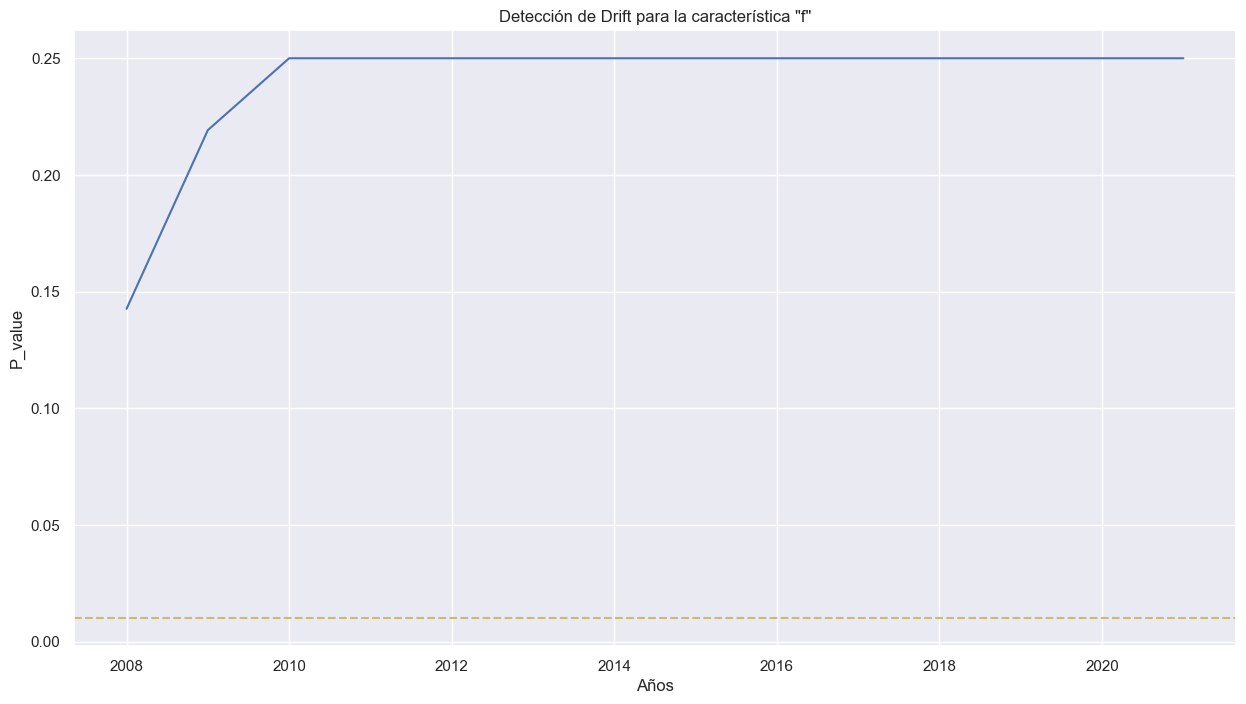

No se detectó drift en el año 2008 con un p-valor de 0.25
No se detectó drift en el año 2009 con un p-valor de 0.25
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.25
No se detectó drift en el año 2012 con un p-valor de 0.25
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.25
No se detectó drift en el año 2015 con un p-valor de 0.25
No se detectó drift en el año 2016 con un p-valor de 0.25
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.25
No se detectó drift en el año 2019 con un p-valor de 0.25
No se detectó drift en el año 2020 con un p-valor de 0.25
No se detectó drift en el año 2021 con un p-valor de 0.022452038174633974


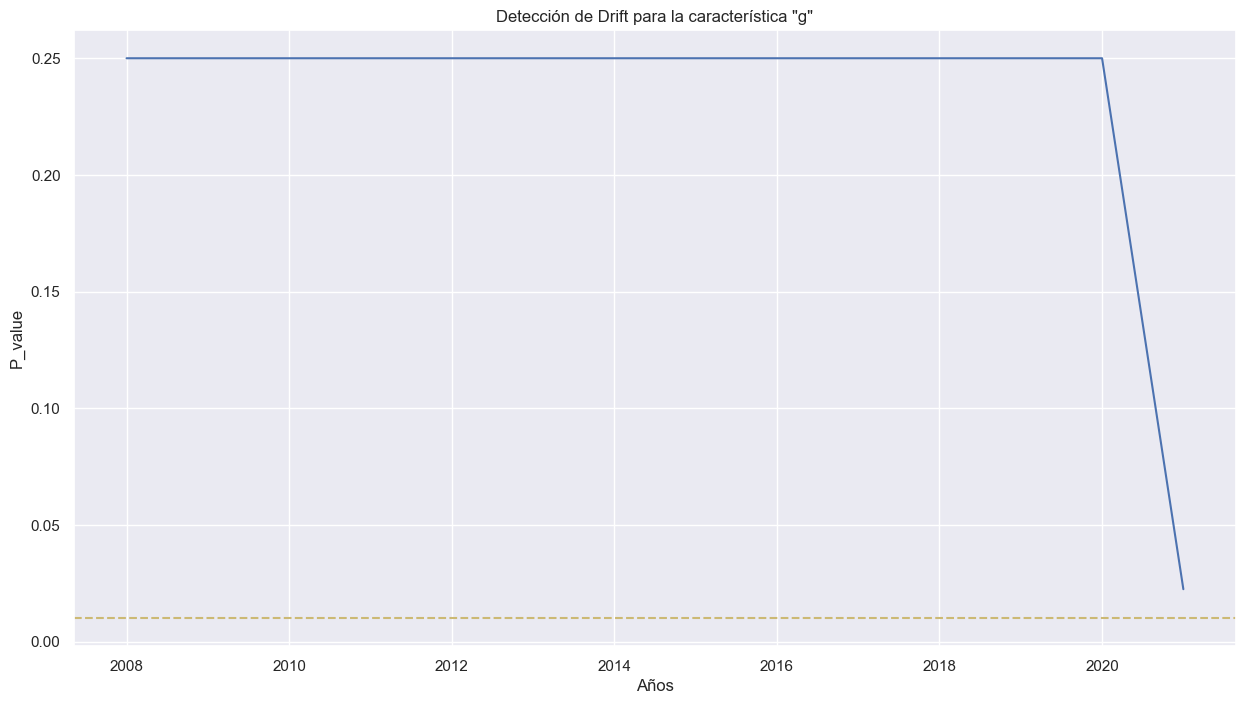

No se detectó drift en el año 2008 con un p-valor de 0.25
No se detectó drift en el año 2009 con un p-valor de 0.25
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.25
No se detectó drift en el año 2012 con un p-valor de 0.25
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.25
No se detectó drift en el año 2015 con un p-valor de 0.25
No se detectó drift en el año 2016 con un p-valor de 0.25
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.17761592208471655
Drift detectado en el año 2019 con un p-valor de 0.001
Drift detectado en el año 2020 con un p-valor de 0.001
Drift detectado en el año 2021 con un p-valor de 0.001


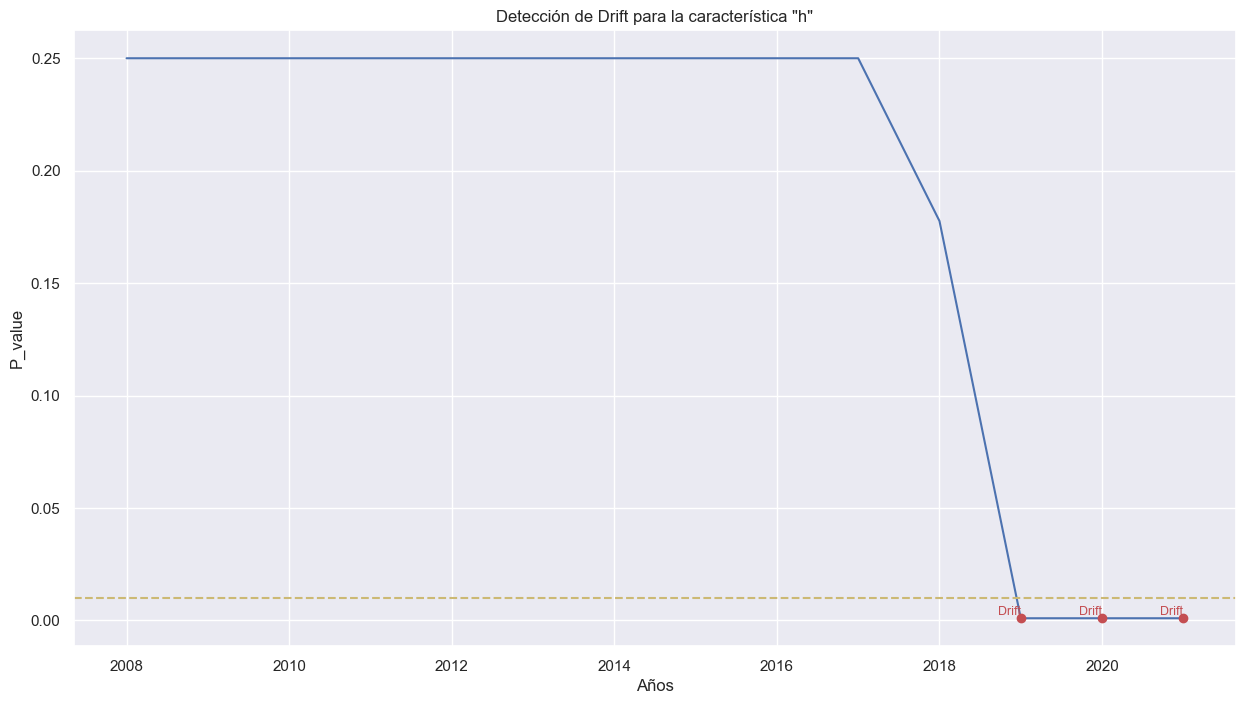

No se detectó drift en el año 2008 con un p-valor de 0.25
No se detectó drift en el año 2009 con un p-valor de 0.25
No se detectó drift en el año 2010 con un p-valor de 0.25
No se detectó drift en el año 2011 con un p-valor de 0.25
No se detectó drift en el año 2012 con un p-valor de 0.25
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.25
No se detectó drift en el año 2015 con un p-valor de 0.25
No se detectó drift en el año 2016 con un p-valor de 0.25
No se detectó drift en el año 2017 con un p-valor de 0.21723418199107178
No se detectó drift en el año 2018 con un p-valor de 0.25
No se detectó drift en el año 2019 con un p-valor de 0.25
No se detectó drift en el año 2020 con un p-valor de 0.25
No se detectó drift en el año 2021 con un p-valor de 0.25


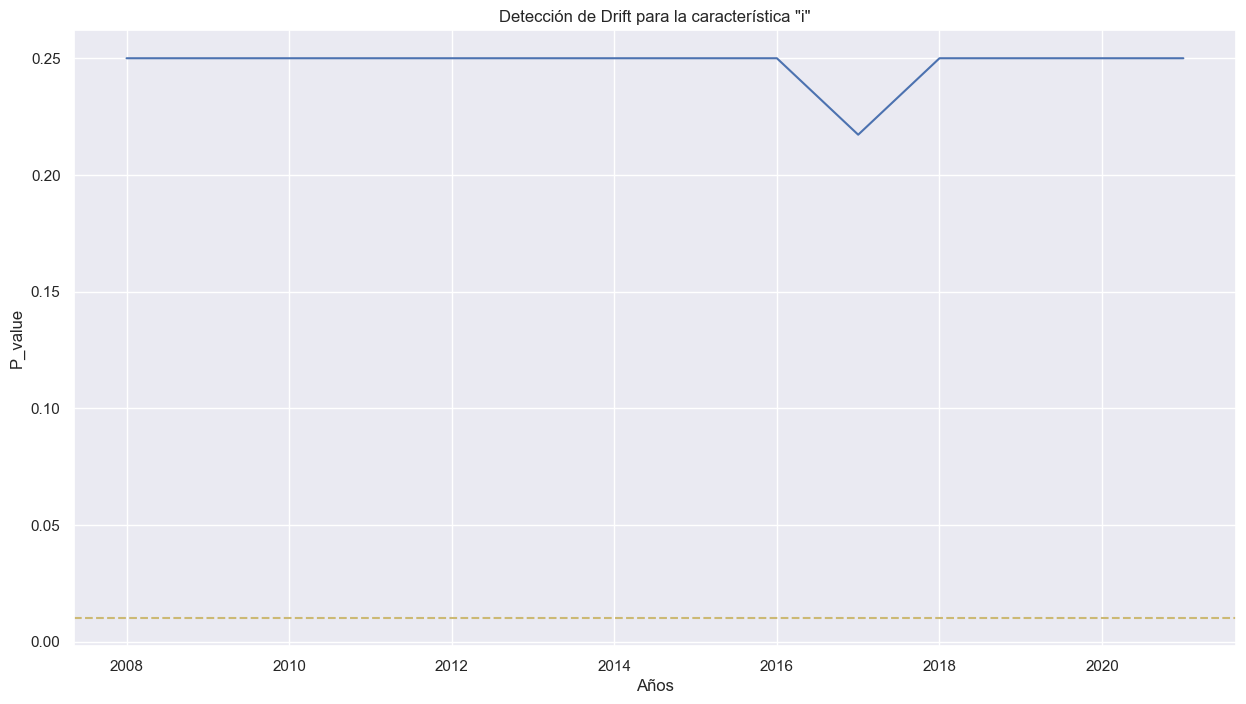

No se detectó drift en el año 2008 con un p-valor de 0.25
No se detectó drift en el año 2009 con un p-valor de 0.216066708607218
No se detectó drift en el año 2010 con un p-valor de 0.22145307447707752
No se detectó drift en el año 2011 con un p-valor de 0.25
No se detectó drift en el año 2012 con un p-valor de 0.0399563300642531
No se detectó drift en el año 2013 con un p-valor de 0.25
No se detectó drift en el año 2014 con un p-valor de 0.13116251070668655
No se detectó drift en el año 2015 con un p-valor de 0.25
Drift detectado en el año 2016 con un p-valor de 0.002458809562254641
No se detectó drift en el año 2017 con un p-valor de 0.25
No se detectó drift en el año 2018 con un p-valor de 0.25
No se detectó drift en el año 2019 con un p-valor de 0.24528281432150528
No se detectó drift en el año 2020 con un p-valor de 0.1269288061887992
Drift detectado en el año 2021 con un p-valor de 0.001


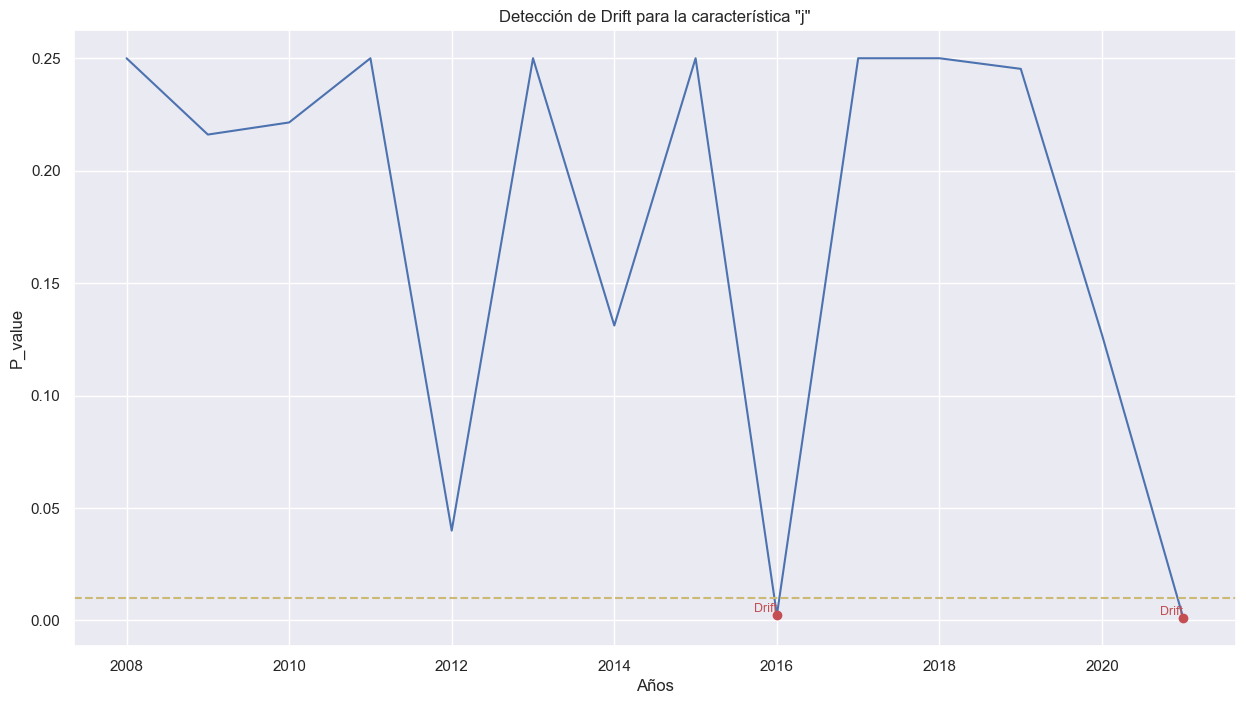

In [23]:
year = np.array(range(2008,2022))
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
values_df = pd.DataFrame(columns = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])

for feat in range(len(features)):
    anderson_detector = AndersonDarlingTest()
    _ = anderson_detector.fit(X=np.array(X_ref.iloc[:,feat]))
    
    p_values = []
    
    for i, batch in enumerate(batch_generator(np.array(X_t0.iloc[:,feat]), 20000)):
        drift_detection = anderson_detector.compare(batch)
        p_values.append(drift_detection[0].p_value)
    
        if drift_detection[0].p_value  < 0.01:
            print(f"Drift detectado en el año {year[i]} con un p-valor de {drift_detection[0].p_value}")
        else:
            print(f"No se detectó drift en el año {year[i]} con un p-valor de {drift_detection[0].p_value}")
    values_df[features[feat]] = p_values
    plot_drift_detection(year, p_values, features[feat])

In [24]:
heatmap_data = values_df.transpose()

In [25]:
heatmap_data.columns = year

In [26]:
sns.set(rc={"figure.figsize": (15, 8)})

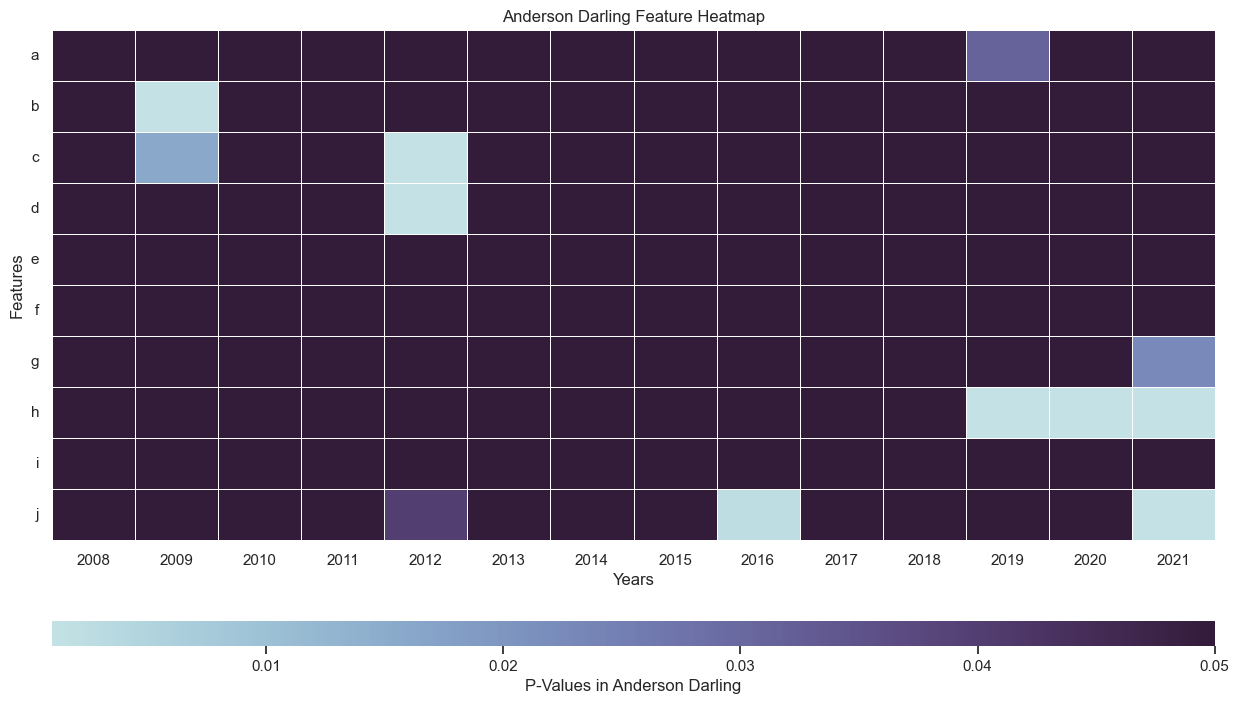

In [27]:
# Setup plot
grid_kws = {"height_ratios": (20, 1), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start = 0.5, rot = -0.4, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    vmax = 0.05,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)

ax.set_title('Anderson Darling Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("P-Values in Anderson Darling")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

### Hellinger Distance

In [28]:
def batch_generator(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]
def plot_drift_detection2(years, distances, feature_name):

    plt.plot(years, distances)
    plt.axhline(y=0.05, color='y', linestyle='--', label='Threshold')

    for i, p in enumerate(distances):
        if p > 0.05:
            plt.plot(years[i], p, 'ro')
            plt.text(years[i], p, 'Drift', fontsize=9, verticalalignment='bottom', horizontalalignment='right', color='r')
    
    plt.xlabel('Años')
    plt.ylabel('Distancia')
    plt.title(f'Detección de Drift para la característica "{feature_name}"')
    plt.show()

In [29]:
from frouros.detectors.data_drift import HellingerDistance

No se detectó drift en el año 2008 con una distancia de 0.010424463732982996
No se detectó drift en el año 2009 con una distancia de 0.014432243586863281
No se detectó drift en el año 2010 con una distancia de 0.009937734957308625
No se detectó drift en el año 2011 con una distancia de 0.010105775357622129
No se detectó drift en el año 2012 con una distancia de 0.007783438955124794
No se detectó drift en el año 2013 con una distancia de 0.012774324938393325
No se detectó drift en el año 2014 con una distancia de 0.0067064890849970245
No se detectó drift en el año 2015 con una distancia de 0.008229634128640273
No se detectó drift en el año 2016 con una distancia de 0.011794014340760472
No se detectó drift en el año 2017 con una distancia de 0.006652089409336738
No se detectó drift en el año 2018 con una distancia de 0.012994594383330648
No se detectó drift en el año 2019 con una distancia de 0.016110134298195466
No se detectó drift en el año 2020 con una distancia de 0.00736358058055612

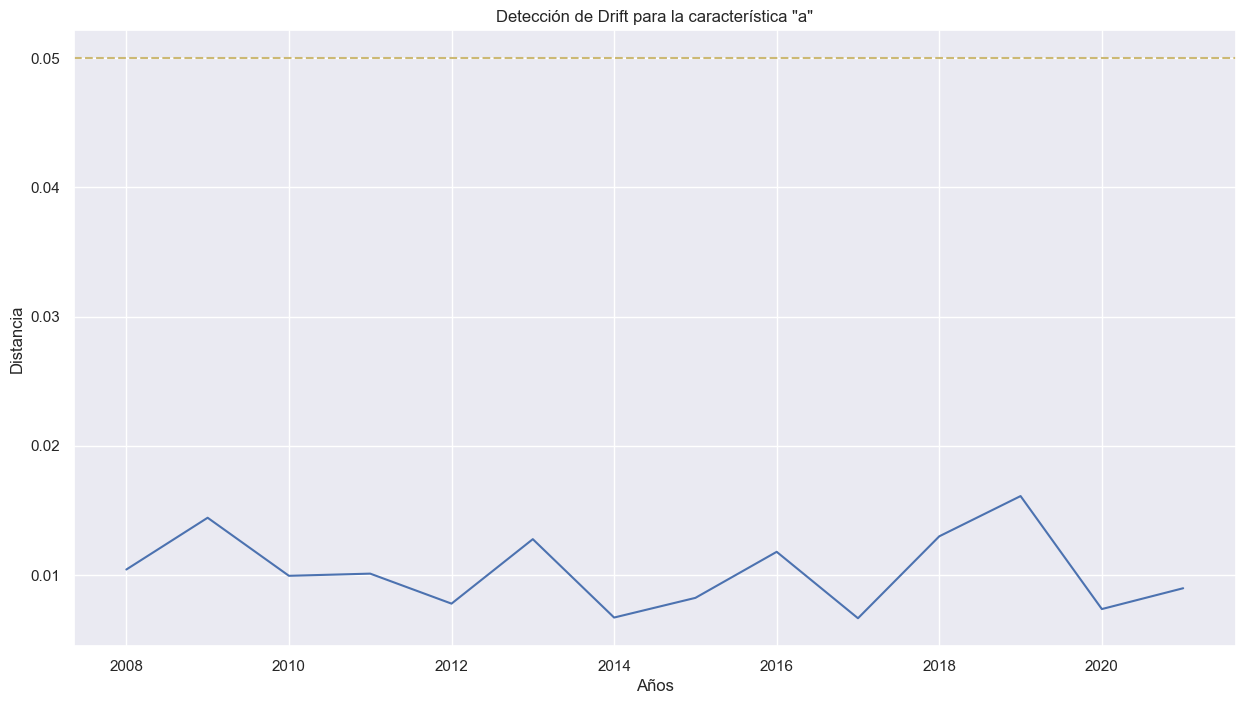

No se detectó drift en el año 2008 con una distancia de 0.010169815588914381
Drift detectado en el año 2009 con una distancia de 1.0
No se detectó drift en el año 2010 con una distancia de 0.013190379929536835
No se detectó drift en el año 2011 con una distancia de 0.009761967288499901
No se detectó drift en el año 2012 con una distancia de 0.014896439425654166
No se detectó drift en el año 2013 con una distancia de 0.012046544594103346
No se detectó drift en el año 2014 con una distancia de 0.011215457382774128
No se detectó drift en el año 2015 con una distancia de 0.01027674966074775
No se detectó drift en el año 2016 con una distancia de 0.010285049956839962
No se detectó drift en el año 2017 con una distancia de 0.007804906969099179
No se detectó drift en el año 2018 con una distancia de 0.005386892036613813
No se detectó drift en el año 2019 con una distancia de 0.011387587360157627
No se detectó drift en el año 2020 con una distancia de 0.009544431282770442
No se detectó drift e

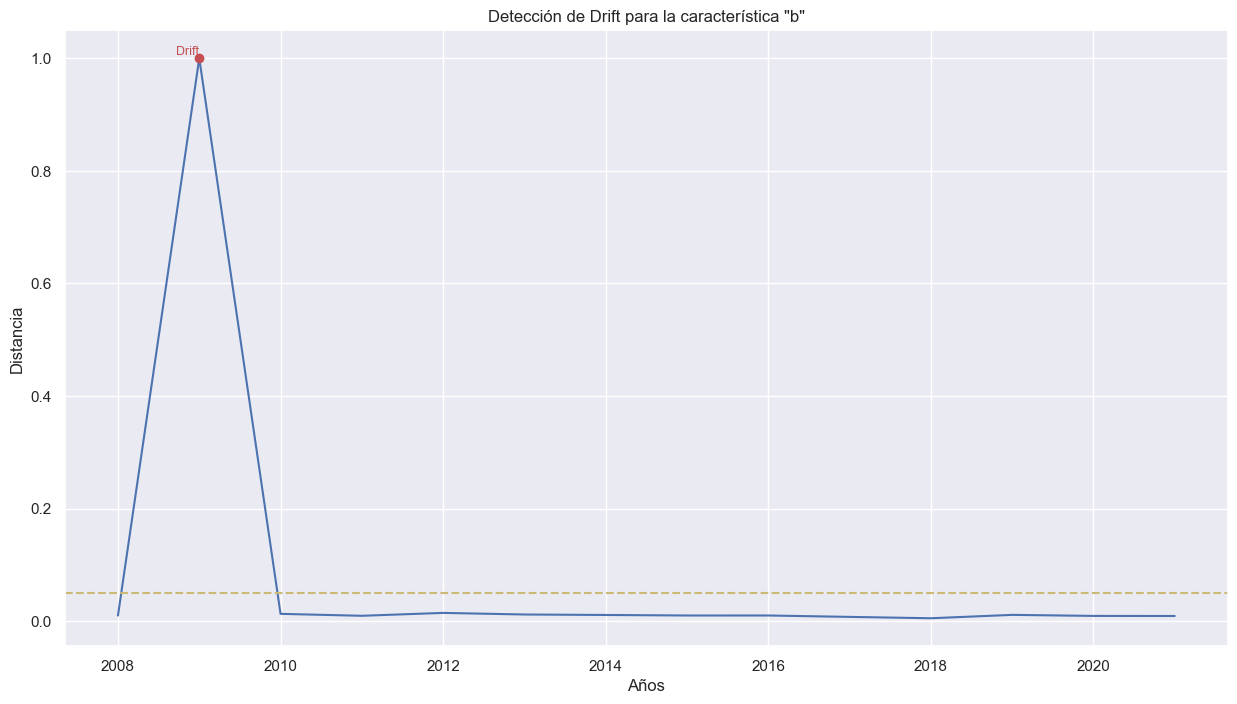

No se detectó drift en el año 2008 con una distancia de 0.010834947954583228
No se detectó drift en el año 2009 con una distancia de 0.012387209266510428
No se detectó drift en el año 2010 con una distancia de 0.007409196003195066
No se detectó drift en el año 2011 con una distancia de 0.00838666050961161
Drift detectado en el año 2012 con una distancia de 0.058224733362448815
No se detectó drift en el año 2013 con una distancia de 0.009530854413281775
No se detectó drift en el año 2014 con una distancia de 0.009800774115259711
No se detectó drift en el año 2015 con una distancia de 0.01173162514345315
No se detectó drift en el año 2016 con una distancia de 0.011553057290297816
No se detectó drift en el año 2017 con una distancia de 0.013791946332219739
No se detectó drift en el año 2018 con una distancia de 0.015175830112990937
No se detectó drift en el año 2019 con una distancia de 0.00858133822832916
No se detectó drift en el año 2020 con una distancia de 0.011679337708654505
No se 

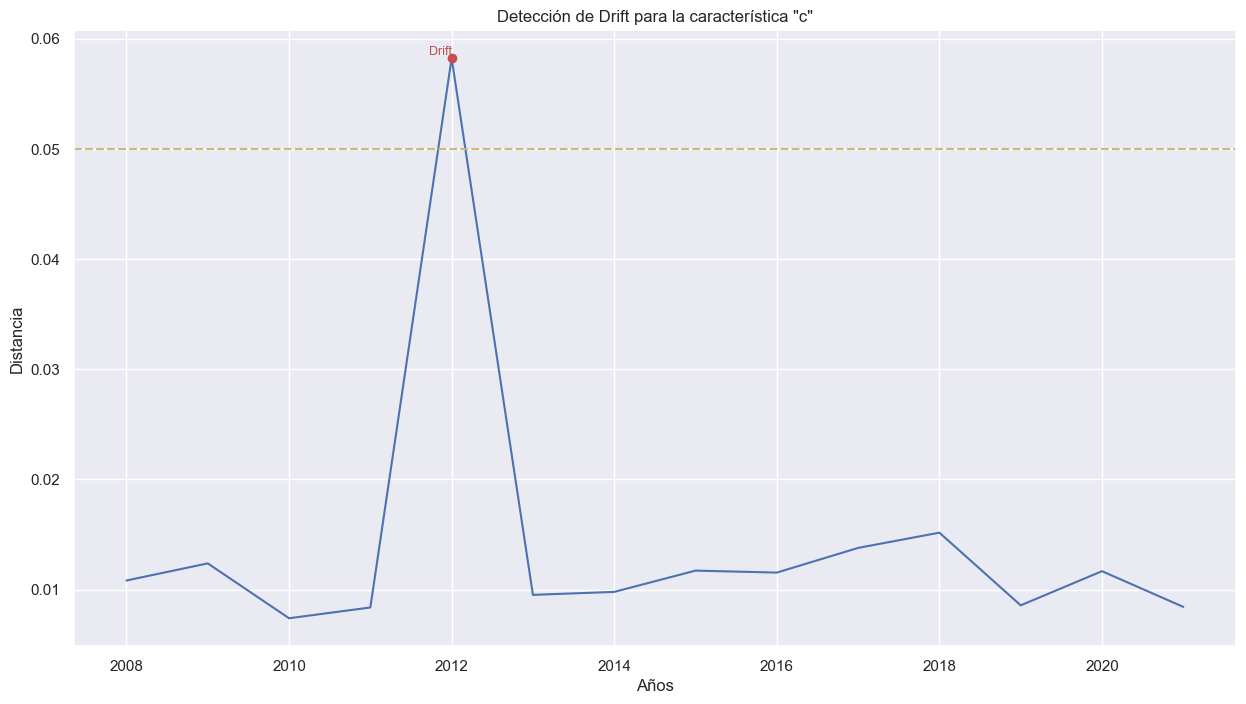

No se detectó drift en el año 2008 con una distancia de 0.013172555058398011
No se detectó drift en el año 2009 con una distancia de 0.009320601692411098
No se detectó drift en el año 2010 con una distancia de 0.00953164896237313
No se detectó drift en el año 2011 con una distancia de 0.009568706987873278
Drift detectado en el año 2012 con una distancia de 0.23238542365973822
No se detectó drift en el año 2013 con una distancia de 0.00953413931623707
No se detectó drift en el año 2014 con una distancia de 0.008719380911873539
No se detectó drift en el año 2015 con una distancia de 0.01213814162120785
No se detectó drift en el año 2016 con una distancia de 0.010709758127599976
No se detectó drift en el año 2017 con una distancia de 0.009827100678200187
No se detectó drift en el año 2018 con una distancia de 0.008521247088977392
No se detectó drift en el año 2019 con una distancia de 0.01113171075892633
No se detectó drift en el año 2020 con una distancia de 0.01094052739043756
No se det

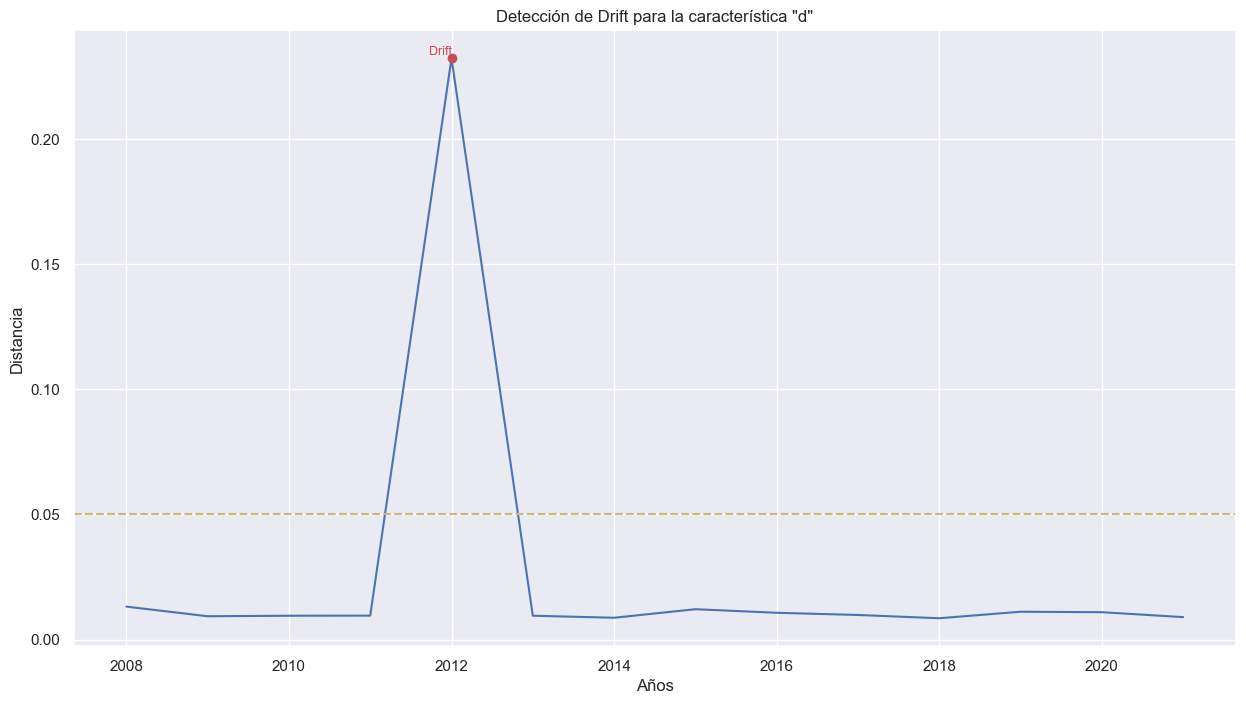

No se detectó drift en el año 2008 con una distancia de 0.005970775874941781
No se detectó drift en el año 2009 con una distancia de 0.01117988250754175
No se detectó drift en el año 2010 con una distancia de 0.0063341661243600245
No se detectó drift en el año 2011 con una distancia de 0.014955703109226582
No se detectó drift en el año 2012 con una distancia de 0.012871107113356414
No se detectó drift en el año 2013 con una distancia de 0.008900316577841271
No se detectó drift en el año 2014 con una distancia de 0.007808895823697852
No se detectó drift en el año 2015 con una distancia de 0.008704438202257305
No se detectó drift en el año 2016 con una distancia de 0.009338308278376894
No se detectó drift en el año 2017 con una distancia de 0.010009206799100757
No se detectó drift en el año 2018 con una distancia de 0.008656530063071915
No se detectó drift en el año 2019 con una distancia de 0.006803804288418136
No se detectó drift en el año 2020 con una distancia de 0.012632572189879019

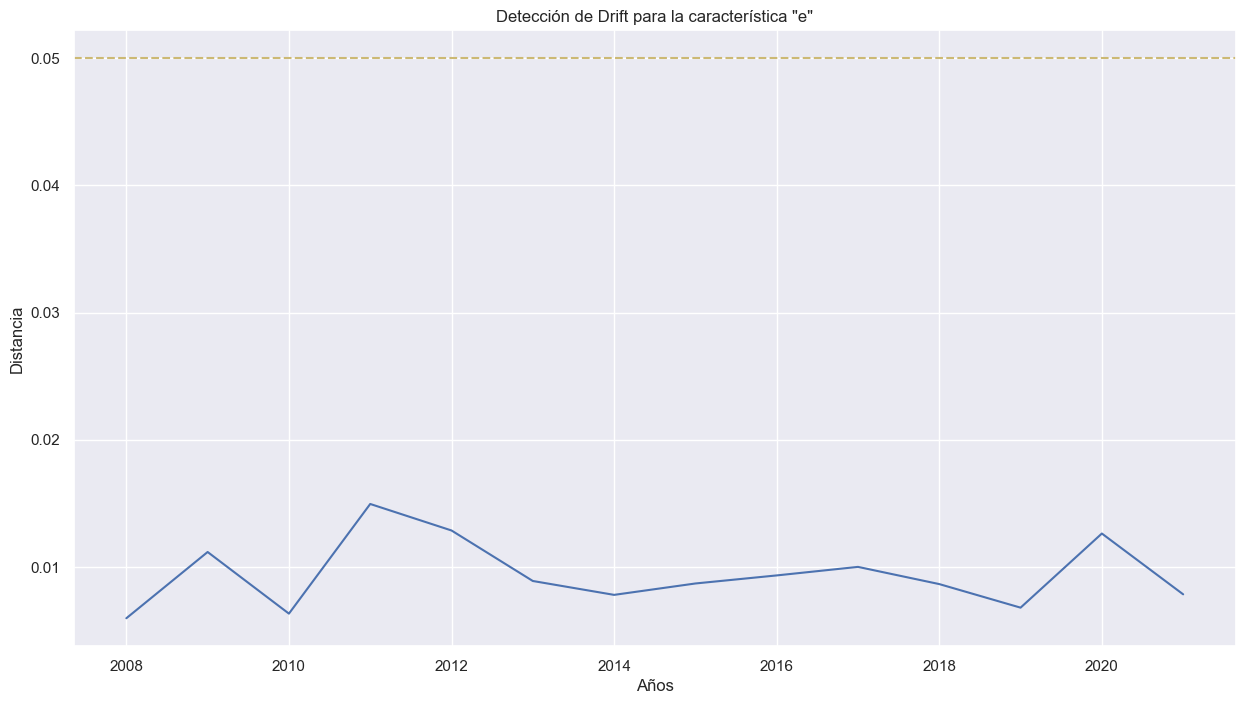

No se detectó drift en el año 2008 con una distancia de 0.009258647817530295
No se detectó drift en el año 2009 con una distancia de 0.011015840158874595
No se detectó drift en el año 2010 con una distancia de 0.007897034183776516
No se detectó drift en el año 2011 con una distancia de 0.012081415314269718
No se detectó drift en el año 2012 con una distancia de 0.011961292044021493
No se detectó drift en el año 2013 con una distancia de 0.006504484884103395
No se detectó drift en el año 2014 con una distancia de 0.007681995502813104
No se detectó drift en el año 2015 con una distancia de 0.011362340054112399
No se detectó drift en el año 2016 con una distancia de 0.00957787143261699
No se detectó drift en el año 2017 con una distancia de 0.00696044230522774
No se detectó drift en el año 2018 con una distancia de 0.00455319365699842
No se detectó drift en el año 2019 con una distancia de 0.013284596519924616
No se detectó drift en el año 2020 con una distancia de 0.007135405195937413
No

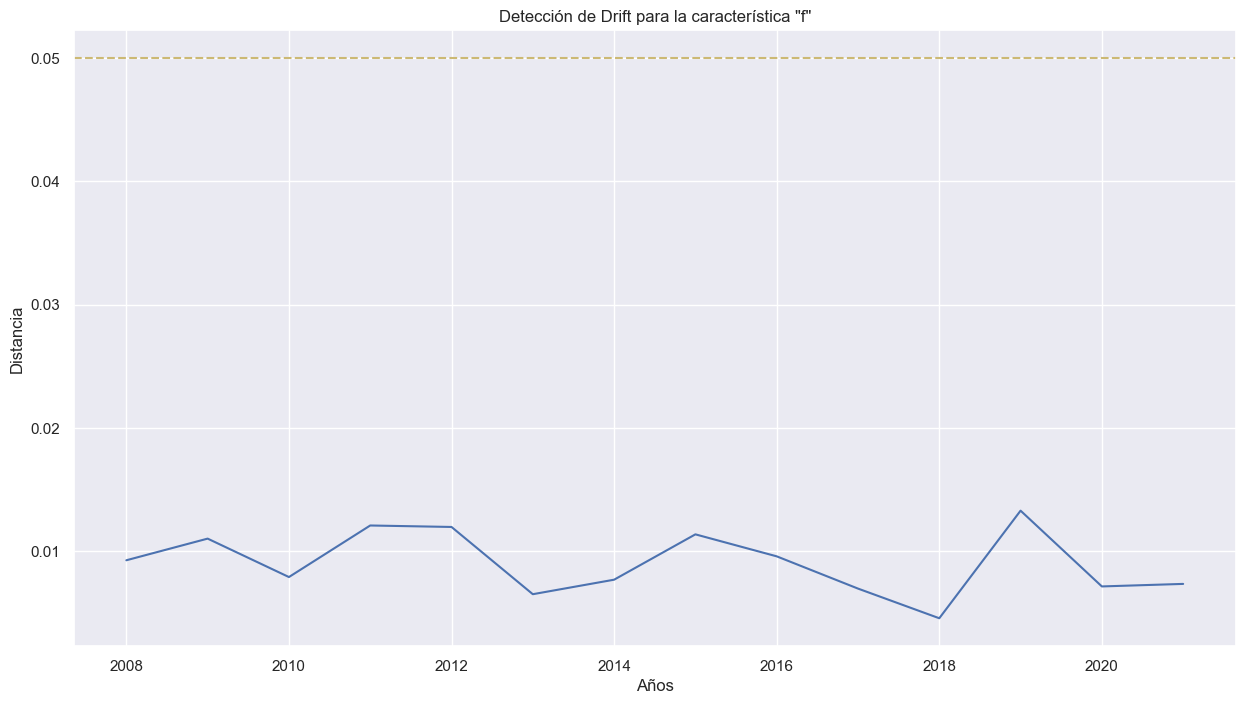

No se detectó drift en el año 2008 con una distancia de 0.00644391372631756
No se detectó drift en el año 2009 con una distancia de 0.015586065349252953
No se detectó drift en el año 2010 con una distancia de 0.014819341917371331
No se detectó drift en el año 2011 con una distancia de 0.01127192124790753
No se detectó drift en el año 2012 con una distancia de 0.011141123408076966
No se detectó drift en el año 2013 con una distancia de 0.013606948847370636
No se detectó drift en el año 2014 con una distancia de 0.009857124748137956
No se detectó drift en el año 2015 con una distancia de 0.009248314649443154
No se detectó drift en el año 2016 con una distancia de 0.009601733722520775
No se detectó drift en el año 2017 con una distancia de 0.011339666863090984
No se detectó drift en el año 2018 con una distancia de 0.008071610982757027
No se detectó drift en el año 2019 con una distancia de 0.00920657136594136
No se detectó drift en el año 2020 con una distancia de 0.010699182648274885
No

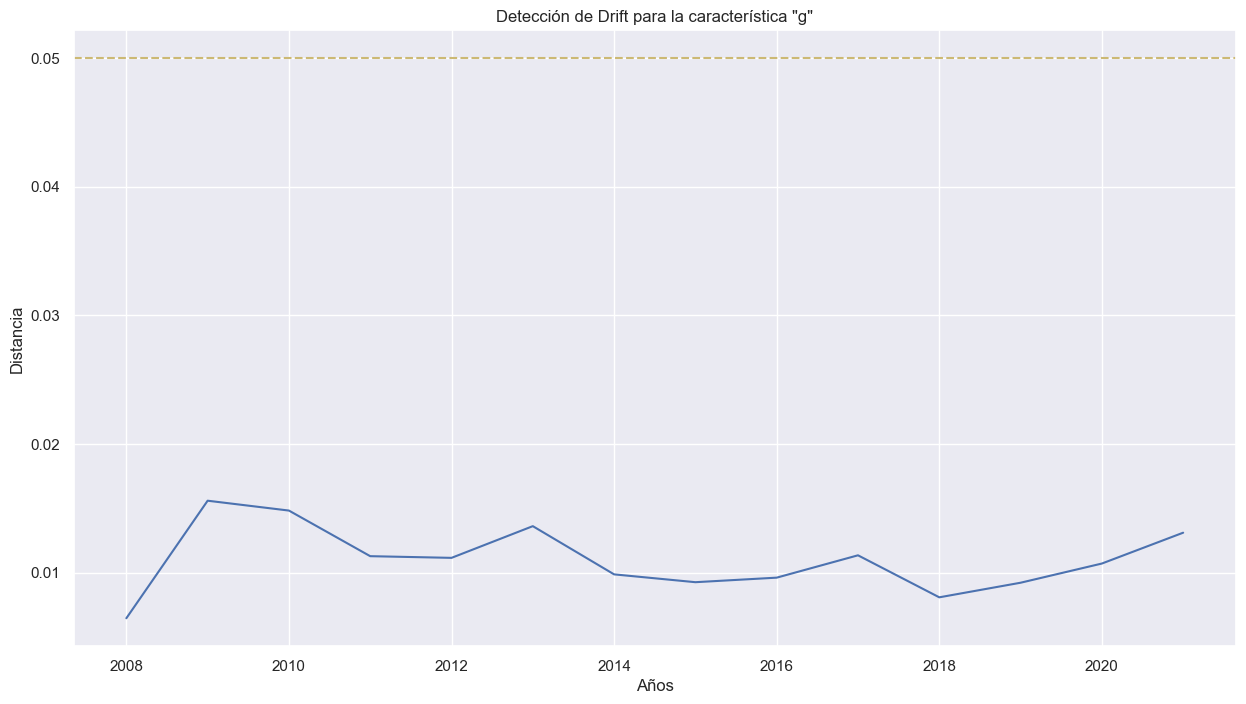

No se detectó drift en el año 2008 con una distancia de 0.009006292585821689
No se detectó drift en el año 2009 con una distancia de 0.010604167492461963
No se detectó drift en el año 2010 con una distancia de 0.012286146823194745
No se detectó drift en el año 2011 con una distancia de 0.007316430594666771
No se detectó drift en el año 2012 con una distancia de 0.011081817005840718
No se detectó drift en el año 2013 con una distancia de 0.010777001206490859
No se detectó drift en el año 2014 con una distancia de 0.011155596916537515
No se detectó drift en el año 2015 con una distancia de 0.012924561086896836
No se detectó drift en el año 2016 con una distancia de 0.008496022943288863
No se detectó drift en el año 2017 con una distancia de 0.010799963380286303
No se detectó drift en el año 2018 con una distancia de 0.00915190190876397
Drift detectado en el año 2019 con una distancia de 0.970133217395876
Drift detectado en el año 2020 con una distancia de 0.9655161759740784
Drift detecta

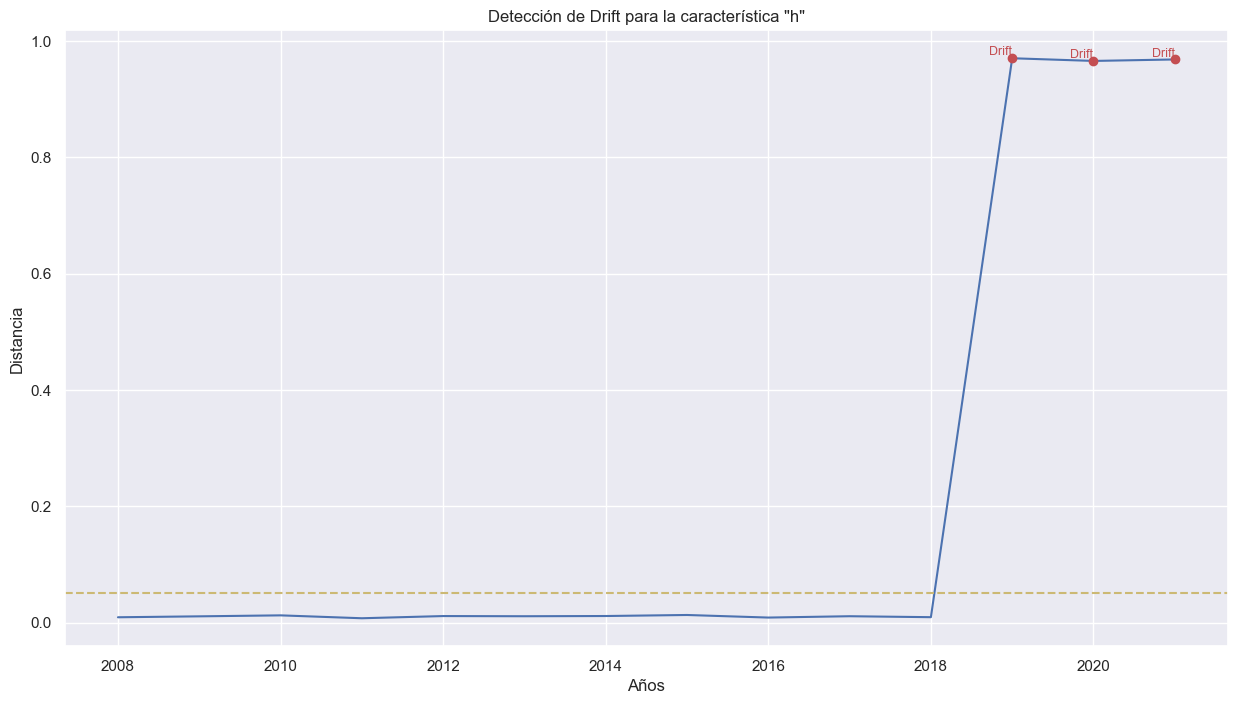

No se detectó drift en el año 2008 con una distancia de 0.00926098369447319
No se detectó drift en el año 2009 con una distancia de 0.014009006028761593
No se detectó drift en el año 2010 con una distancia de 0.012783060301152019
No se detectó drift en el año 2011 con una distancia de 0.011321085496760802
No se detectó drift en el año 2012 con una distancia de 0.008443671562103223
No se detectó drift en el año 2013 con una distancia de 0.013743988251265883
No se detectó drift en el año 2014 con una distancia de 0.009183737878209506
No se detectó drift en el año 2015 con una distancia de 0.013990887210591335
No se detectó drift en el año 2016 con una distancia de 0.008951925827483907
No se detectó drift en el año 2017 con una distancia de 0.014037806134198692
No se detectó drift en el año 2018 con una distancia de 0.013663233154784595
No se detectó drift en el año 2019 con una distancia de 0.012643784150681877
No se detectó drift en el año 2020 con una distancia de 0.00908797531953488
N

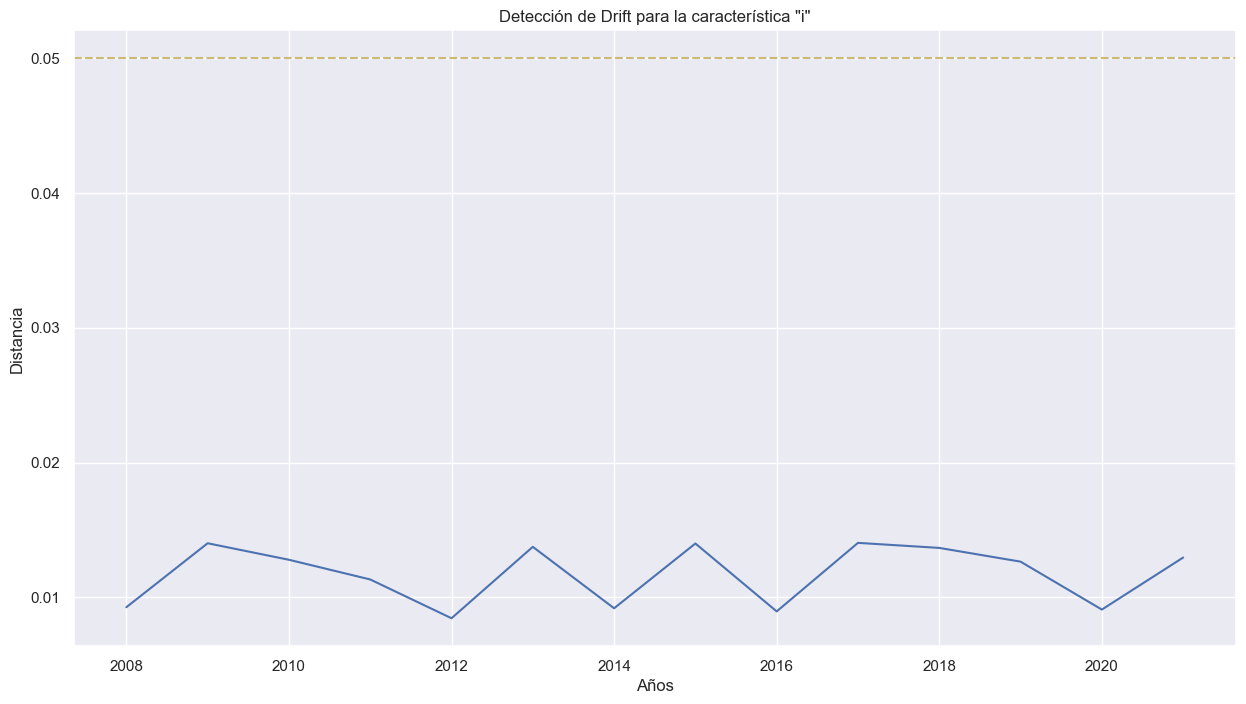

No se detectó drift en el año 2008 con una distancia de 0.009050428765488238
No se detectó drift en el año 2009 con una distancia de 0.012029342065034795
No se detectó drift en el año 2010 con una distancia de 0.012795395998030092
No se detectó drift en el año 2011 con una distancia de 0.009305648384911958
No se detectó drift en el año 2012 con una distancia de 0.013007578467237204
No se detectó drift en el año 2013 con una distancia de 0.013084079098303713
No se detectó drift en el año 2014 con una distancia de 0.015007102835520772
No se detectó drift en el año 2015 con una distancia de 0.010703578429165193
No se detectó drift en el año 2016 con una distancia de 0.016937713682160575
No se detectó drift en el año 2017 con una distancia de 0.014067239451961769
No se detectó drift en el año 2018 con una distancia de 0.007094362952615116
No se detectó drift en el año 2019 con una distancia de 0.013040030126529916
No se detectó drift en el año 2020 con una distancia de 0.0126787607606981
D

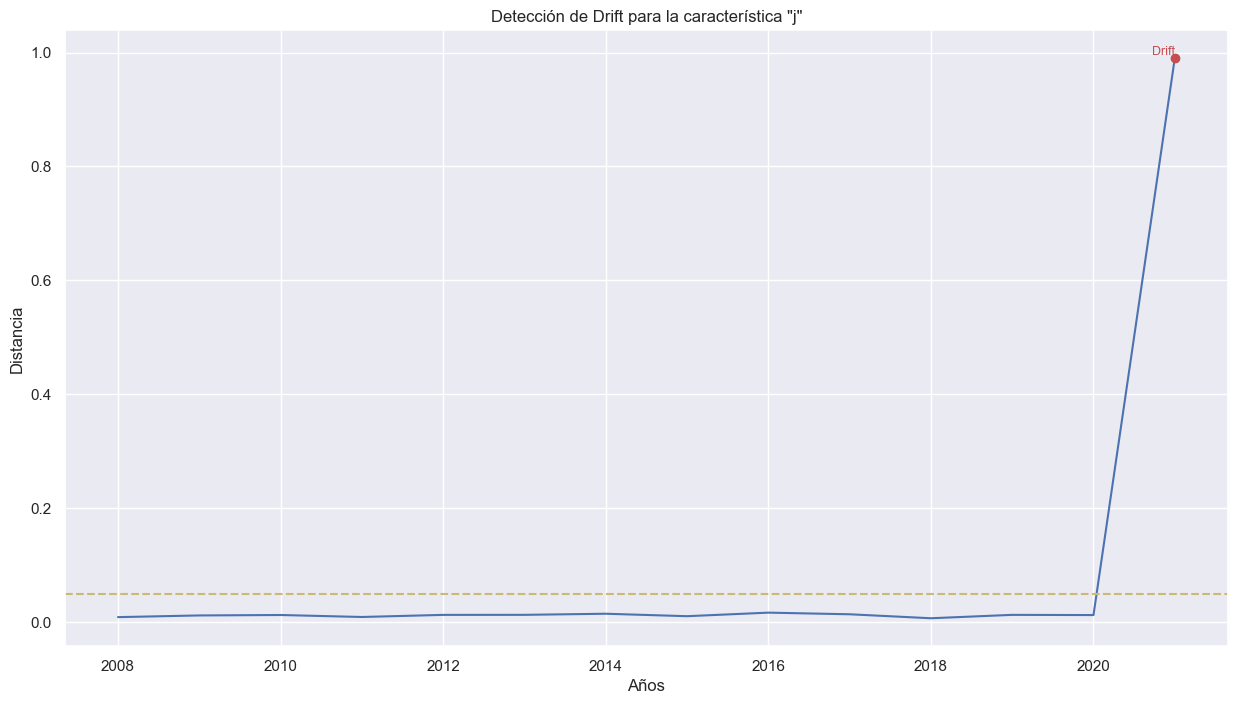

In [30]:
year = np.array(range(2008,2022))
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
values_df = pd.DataFrame(columns = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])

for feat in range(len(features)):
    hellinger_detector = HellingerDistance()
    _ = hellinger_detector.fit(X=np.array(X_ref.iloc[:,feat]))
    
    distances = []
    
    for i, batch in enumerate(batch_generator(np.array(X_t0.iloc[:,feat]), 20000)):
        drift_detection = hellinger_detector.compare(batch)
        distances.append(drift_detection[0].distance)
    
        if drift_detection[0].distance  > 0.05:
            print(f"Drift detectado en el año {year[i]} con una distancia de {drift_detection[0].distance}")
        else:
            print(f"No se detectó drift en el año {year[i]} con una distancia de {drift_detection[0].distance}")
    values_df[features[feat]] = distances
    plot_drift_detection2(year, distances, features[feat])

In [31]:
heatmap_data = values_df.transpose()

In [32]:
heatmap_data.columns = year

In [33]:
sns.set(rc={"figure.figsize": (15, 8)})

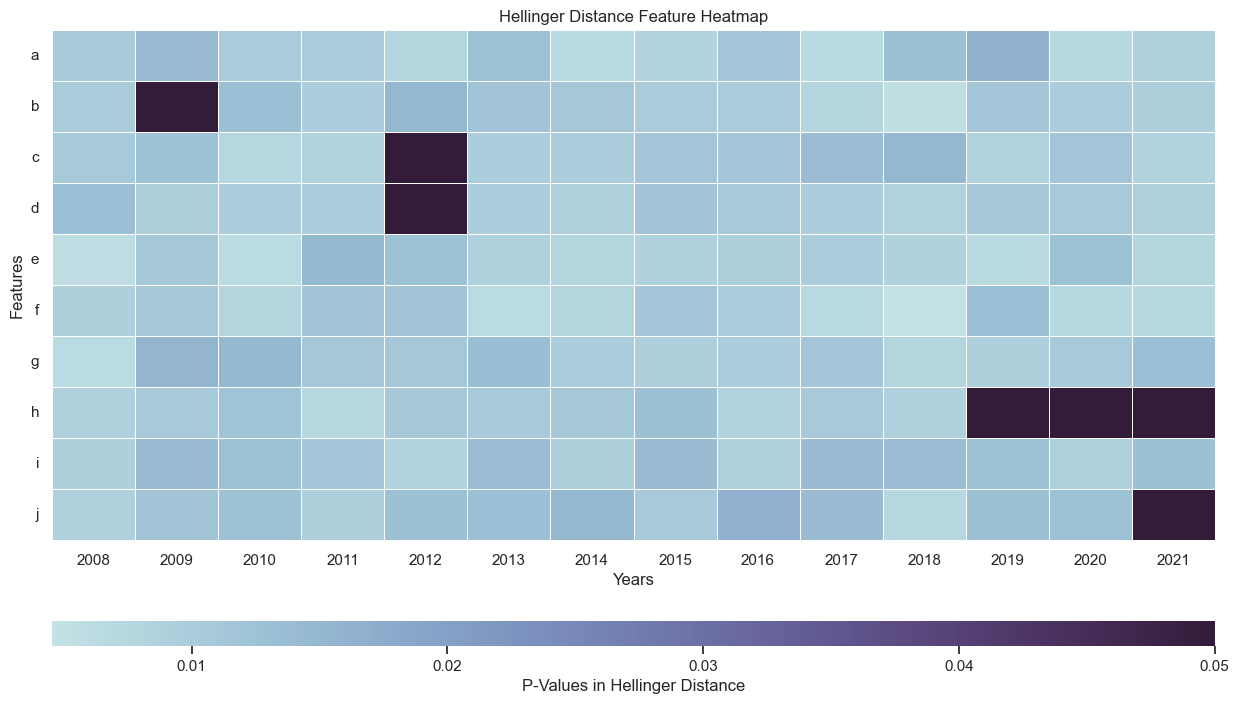

In [34]:
# Setup plot
grid_kws = {"height_ratios": (20, 1), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start = 0.5, rot = -0.4, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    vmax = 0.05,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)

ax.set_title('Hellinger Distance Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("P-Values in Hellinger Distance")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

### Jensen-Shannon Distance

In [35]:
from frouros.detectors.data_drift import JS

No se detectó drift en el año 2008 con una distancia de 0.00626672561381571
No se detectó drift en el año 2009 con una distancia de 0.01360229555564353
No se detectó drift en el año 2010 con una distancia de 0.01050543485826623
No se detectó drift en el año 2011 con una distancia de 0.011241072928452965
No se detectó drift en el año 2012 con una distancia de 0.009367857328680894
No se detectó drift en el año 2013 con una distancia de 0.007972338027704024
No se detectó drift en el año 2014 con una distancia de 0.009364712301826558
No se detectó drift en el año 2015 con una distancia de 0.005880352393945776
No se detectó drift en el año 2016 con una distancia de 0.008077781882172607
No se detectó drift en el año 2017 con una distancia de 0.004886780889006978
No se detectó drift en el año 2018 con una distancia de 0.010081104295461786
No se detectó drift en el año 2019 con una distancia de 0.014084989390625984
No se detectó drift en el año 2020 con una distancia de 0.006785495929459726
No

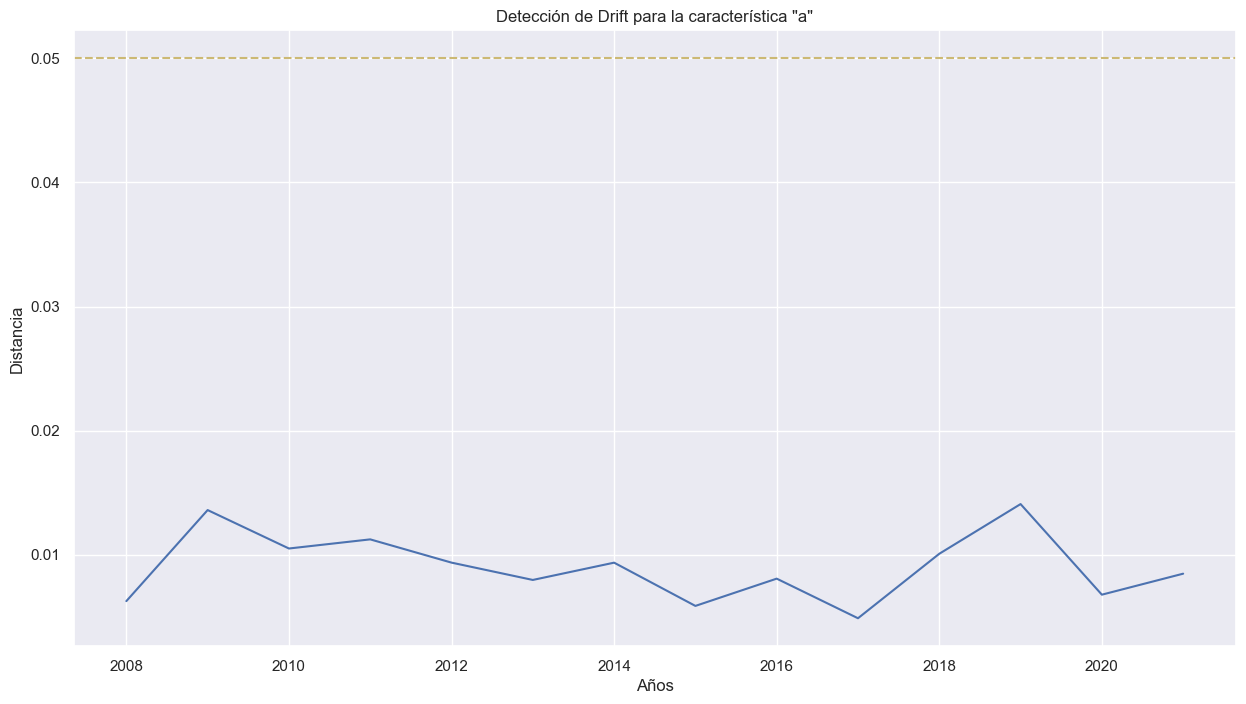

No se detectó drift en el año 2008 con una distancia de 0.008132192561602452
Drift detectado en el año 2009 con una distancia de 0.8325546111576977
No se detectó drift en el año 2010 con una distancia de 0.012645885113302214
No se detectó drift en el año 2011 con una distancia de 0.0059531045903380925
No se detectó drift en el año 2012 con una distancia de 0.015117587812397094
No se detectó drift en el año 2013 con una distancia de 0.00984862291965133
No se detectó drift en el año 2014 con una distancia de 0.012677093251092413
No se detectó drift en el año 2015 con una distancia de 0.007971954567102826
No se detectó drift en el año 2016 con una distancia de 0.012266252432803808
No se detectó drift en el año 2017 con una distancia de 0.004903100283706948
No se detectó drift en el año 2018 con una distancia de 0.0052140896328821285
No se detectó drift en el año 2019 con una distancia de 0.012932406680946971
No se detectó drift en el año 2020 con una distancia de 0.010901177410454765
No s

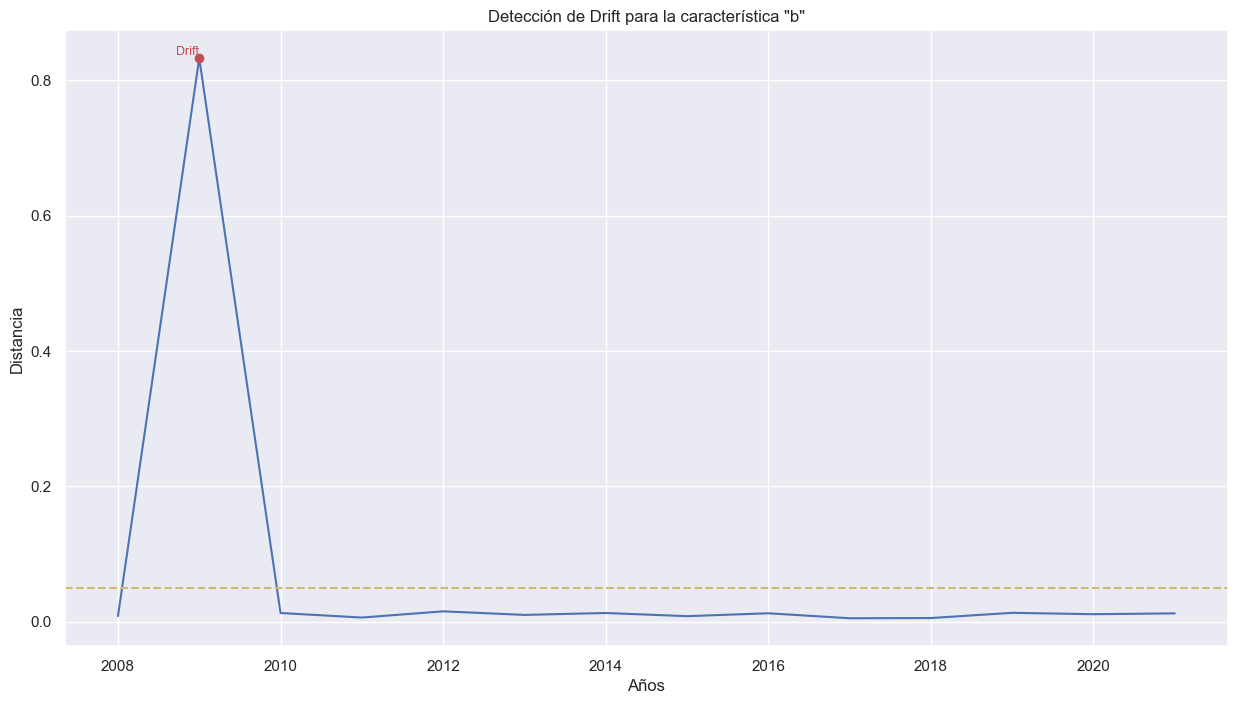

No se detectó drift en el año 2008 con una distancia de 0.009698409802486202
No se detectó drift en el año 2009 con una distancia de 0.009736517108977398
No se detectó drift en el año 2010 con una distancia de 0.007467459468697603
No se detectó drift en el año 2011 con una distancia de 0.008955151665137892
Drift detectado en el año 2012 con una distancia de 0.05261692936228982
No se detectó drift en el año 2013 con una distancia de 0.010850375724041702
No se detectó drift en el año 2014 con una distancia de 0.006843341776105168
No se detectó drift en el año 2015 con una distancia de 0.010884989069059747
No se detectó drift en el año 2016 con una distancia de 0.009938390627552527
No se detectó drift en el año 2017 con una distancia de 0.01249094174849641
No se detectó drift en el año 2018 con una distancia de 0.012740989774932774
No se detectó drift en el año 2019 con una distancia de 0.011508503229141424
No se detectó drift en el año 2020 con una distancia de 0.010486168097897418
No se

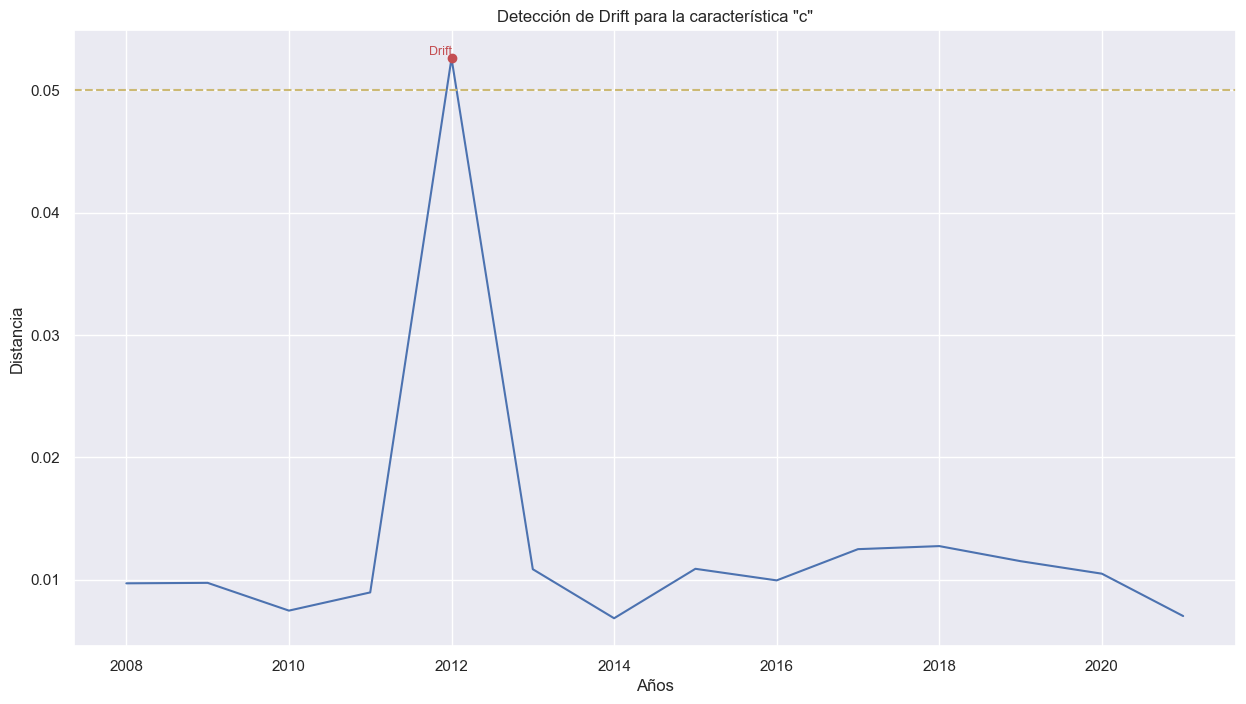

No se detectó drift en el año 2008 con una distancia de 0.008832080510073413
No se detectó drift en el año 2009 con una distancia de 0.008071256930424087
No se detectó drift en el año 2010 con una distancia de 0.011088067459366836
No se detectó drift en el año 2011 con una distancia de 0.008316354670883142
Drift detectado en el año 2012 con una distancia de 0.21933641297496018
No se detectó drift en el año 2013 con una distancia de 0.008865745220912448
No se detectó drift en el año 2014 con una distancia de 0.008842072889629852
No se detectó drift en el año 2015 con una distancia de 0.012969459191980792
No se detectó drift en el año 2016 con una distancia de 0.010214009284467663
No se detectó drift en el año 2017 con una distancia de 0.010507465976065557
No se detectó drift en el año 2018 con una distancia de 0.009051433239313142
No se detectó drift en el año 2019 con una distancia de 0.011639741512050258
No se detectó drift en el año 2020 con una distancia de 0.009856373226822914
No s

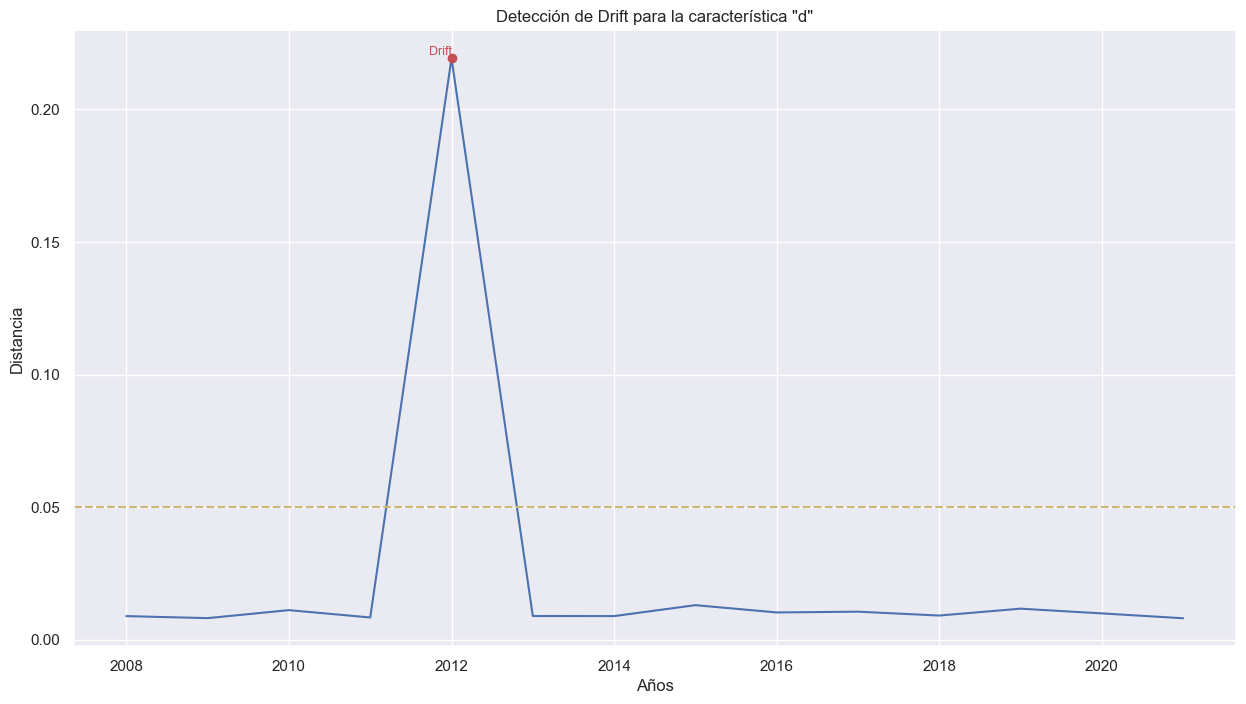

No se detectó drift en el año 2008 con una distancia de 0.0056439326966067
No se detectó drift en el año 2009 con una distancia de 0.008216847807209153
No se detectó drift en el año 2010 con una distancia de 0.00900503756694153
No se detectó drift en el año 2011 con una distancia de 0.009973956342774294
No se detectó drift en el año 2012 con una distancia de 0.011510017576461449
No se detectó drift en el año 2013 con una distancia de 0.007141615336534641
No se detectó drift en el año 2014 con una distancia de 0.007319431399514091
No se detectó drift en el año 2015 con una distancia de 0.004473973003824361
No se detectó drift en el año 2016 con una distancia de 0.009199817655775908
No se detectó drift en el año 2017 con una distancia de 0.009187278975878677
No se detectó drift en el año 2018 con una distancia de 0.004829098769545019
No se detectó drift en el año 2019 con una distancia de 0.007547985285066909
No se detectó drift en el año 2020 con una distancia de 0.011442432187304181
No

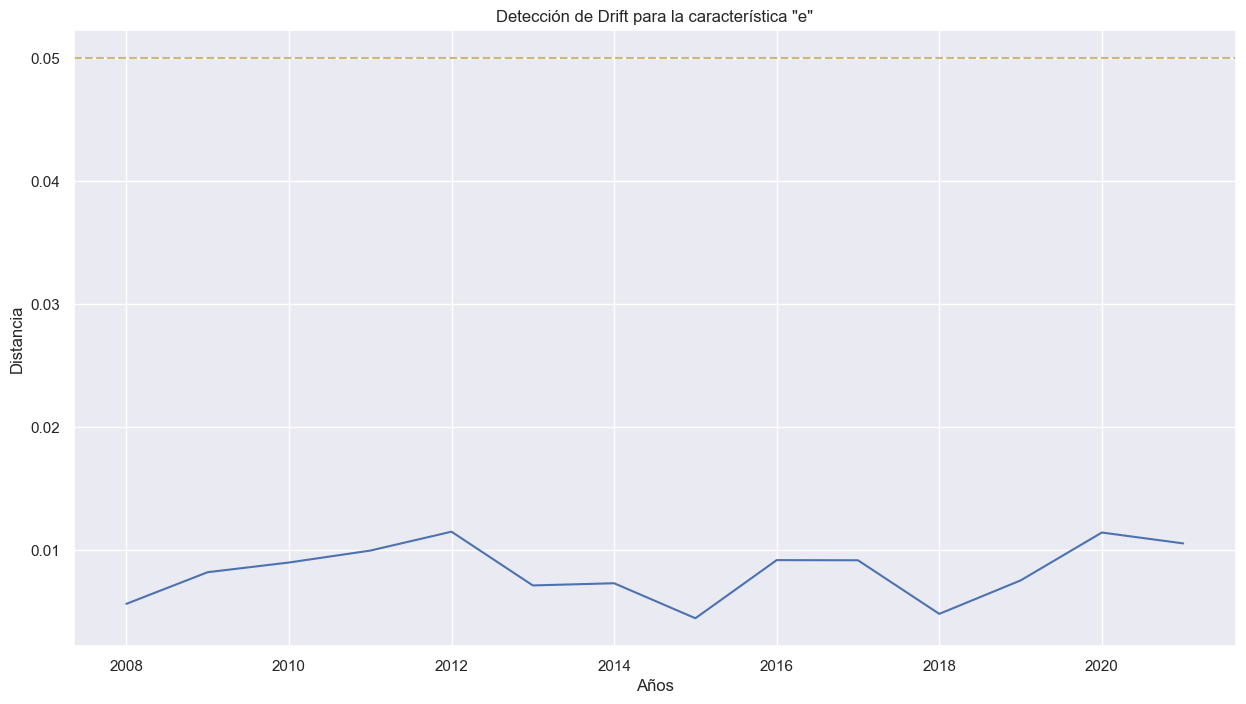

No se detectó drift en el año 2008 con una distancia de 0.010017678890030971
No se detectó drift en el año 2009 con una distancia de 0.00942371105516968
No se detectó drift en el año 2010 con una distancia de 0.00976857507608275
No se detectó drift en el año 2011 con una distancia de 0.009413115378881766
No se detectó drift en el año 2012 con una distancia de 0.011529277686247246
No se detectó drift en el año 2013 con una distancia de 0.009658393264282895
No se detectó drift en el año 2014 con una distancia de 0.007703584105680259
No se detectó drift en el año 2015 con una distancia de 0.011385028871604436
No se detectó drift en el año 2016 con una distancia de 0.00937038235278385
No se detectó drift en el año 2017 con una distancia de 0.005148464399399228
No se detectó drift en el año 2018 con una distancia de 0.006607081181196517
No se detectó drift en el año 2019 con una distancia de 0.013081120511506217
No se detectó drift en el año 2020 con una distancia de 0.008980986540714225
No

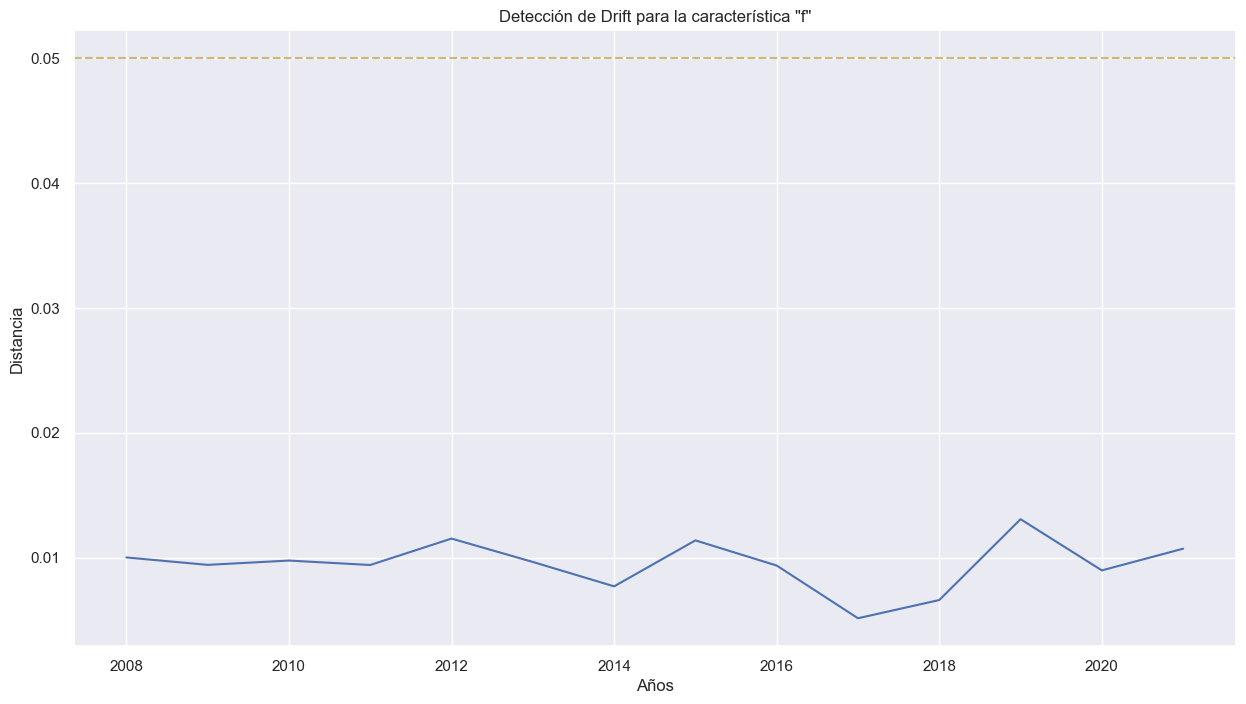

No se detectó drift en el año 2008 con una distancia de 0.006484558064459672
No se detectó drift en el año 2009 con una distancia de 0.015168065930009661
No se detectó drift en el año 2010 con una distancia de 0.012910078951889692
No se detectó drift en el año 2011 con una distancia de 0.008405060225171625
No se detectó drift en el año 2012 con una distancia de 0.008401600400460525
No se detectó drift en el año 2013 con una distancia de 0.01150340293113296
No se detectó drift en el año 2014 con una distancia de 0.006924103880997768
No se detectó drift en el año 2015 con una distancia de 0.01000542403972009
No se detectó drift en el año 2016 con una distancia de 0.0071824535697644415
No se detectó drift en el año 2017 con una distancia de 0.007968819634180403
No se detectó drift en el año 2018 con una distancia de 0.004233922482076241
No se detectó drift en el año 2019 con una distancia de 0.005629984547604047
No se detectó drift en el año 2020 con una distancia de 0.007391591069404607


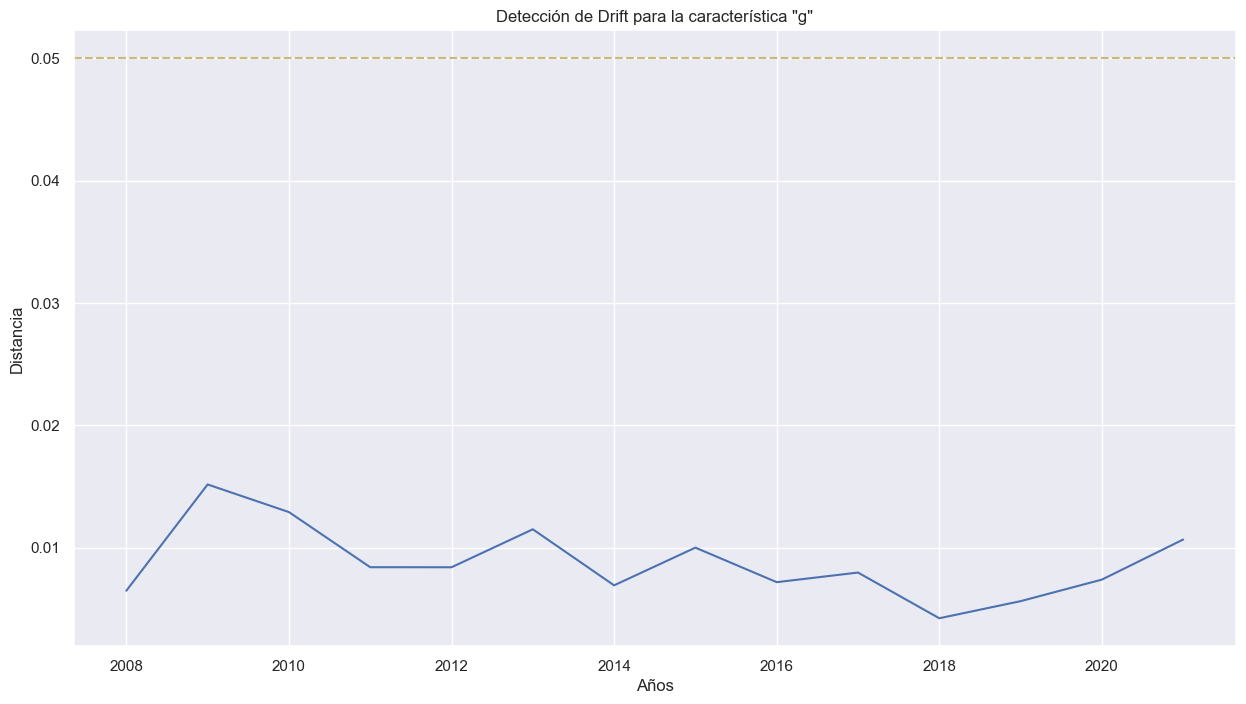

No se detectó drift en el año 2008 con una distancia de 0.011743121655054582
No se detectó drift en el año 2009 con una distancia de 0.010168878615719192
No se detectó drift en el año 2010 con una distancia de 0.012842953872631825
No se detectó drift en el año 2011 con una distancia de 0.0070754776404781125
No se detectó drift en el año 2012 con una distancia de 0.009423480275399103
No se detectó drift en el año 2013 con una distancia de 0.00893195556579484
No se detectó drift en el año 2014 con una distancia de 0.01303105888531639
No se detectó drift en el año 2015 con una distancia de 0.013991581394189923
No se detectó drift en el año 2016 con una distancia de 0.009458555618575006
No se detectó drift en el año 2017 con una distancia de 0.008492239394332782
No se detectó drift en el año 2018 con una distancia de 0.010240489022287415
Drift detectado en el año 2019 con una distancia de 0.8139634560193896
Drift detectado en el año 2020 con una distancia de 0.8136852520613086
Drift detect

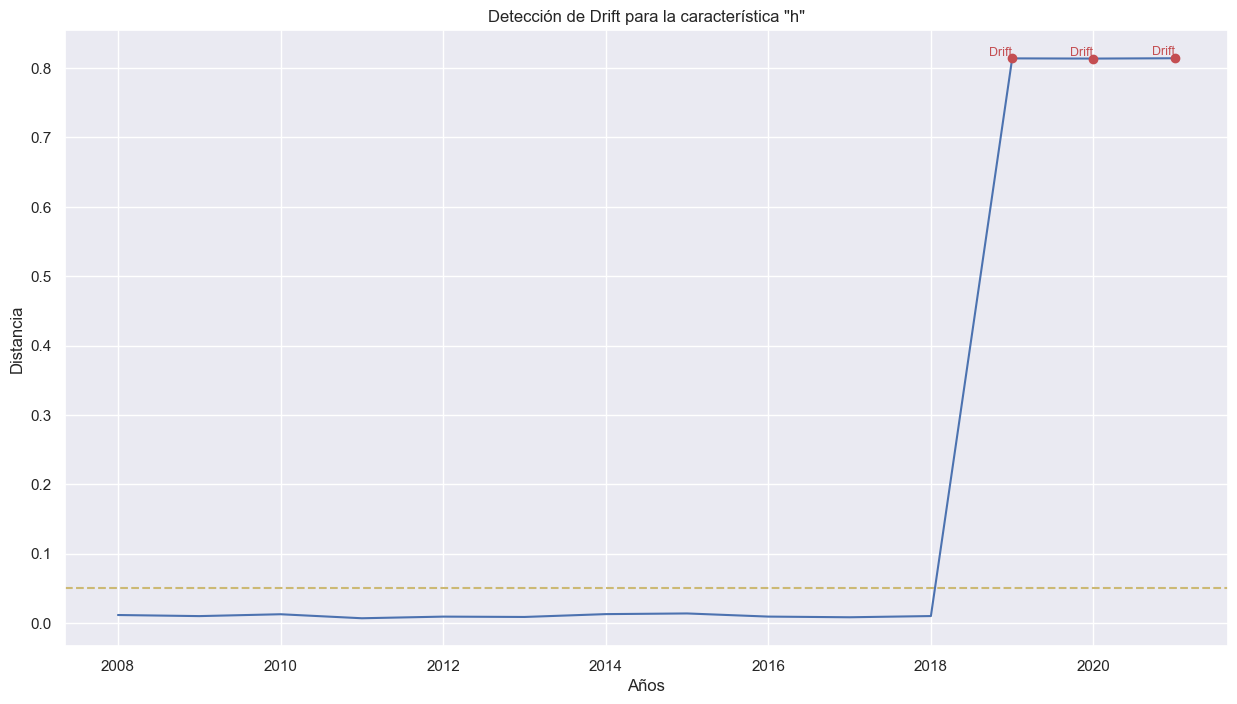

No se detectó drift en el año 2008 con una distancia de 0.008322349445970222
No se detectó drift en el año 2009 con una distancia de 0.013008505509530309
No se detectó drift en el año 2010 con una distancia de 0.012708572034272746
No se detectó drift en el año 2011 con una distancia de 0.011783825662641393
No se detectó drift en el año 2012 con una distancia de 0.007529272518157843
No se detectó drift en el año 2013 con una distancia de 0.013368649366825556
No se detectó drift en el año 2014 con una distancia de 0.009148933644337474
No se detectó drift en el año 2015 con una distancia de 0.011248290125649872
No se detectó drift en el año 2016 con una distancia de 0.009617188457105245
No se detectó drift en el año 2017 con una distancia de 0.012529768743536722
No se detectó drift en el año 2018 con una distancia de 0.01175063888797946
No se detectó drift en el año 2019 con una distancia de 0.010060709298313514
No se detectó drift en el año 2020 con una distancia de 0.008272594064326434


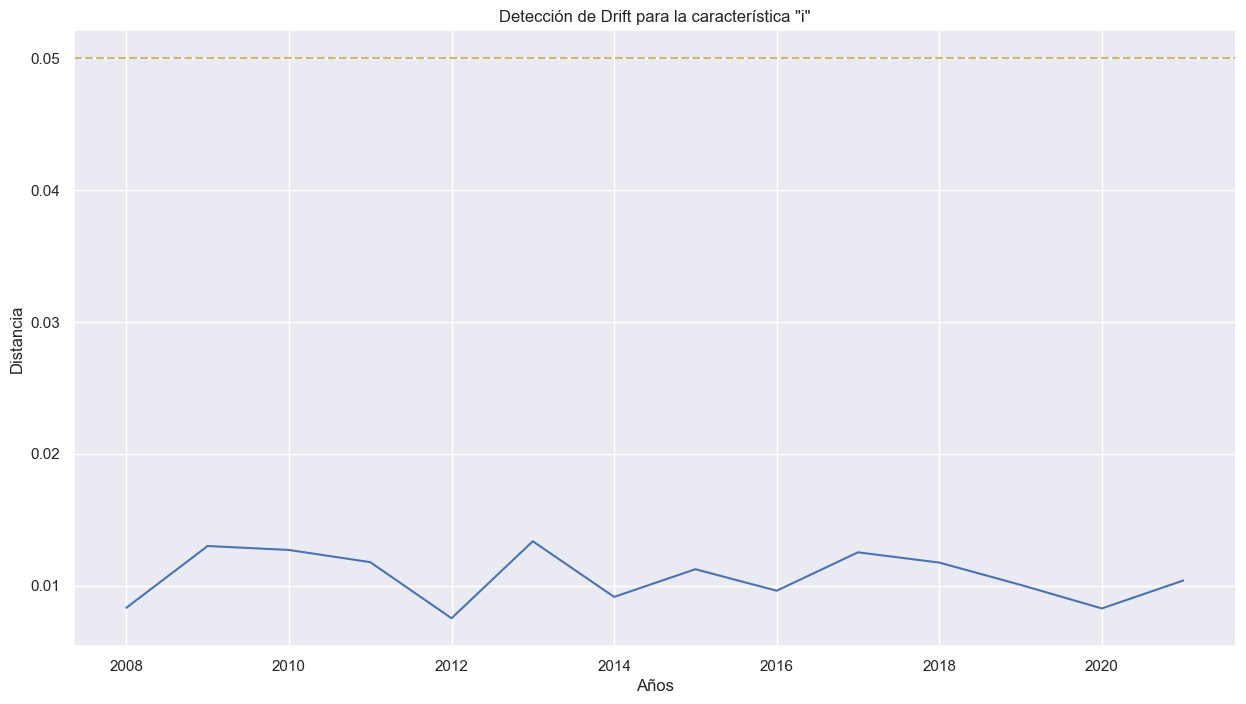

No se detectó drift en el año 2008 con una distancia de 0.012525307022910569
No se detectó drift en el año 2009 con una distancia de 0.013504769083327333
No se detectó drift en el año 2010 con una distancia de 0.009160523119164689
No se detectó drift en el año 2011 con una distancia de 0.007748776654894638
No se detectó drift en el año 2012 con una distancia de 0.008975480191363155
No se detectó drift en el año 2013 con una distancia de 0.009938808748491835
No se detectó drift en el año 2014 con una distancia de 0.011517772455272449
No se detectó drift en el año 2015 con una distancia de 0.008267812027967933
No se detectó drift en el año 2016 con una distancia de 0.01283209968027654
No se detectó drift en el año 2017 con una distancia de 0.00973956690035281
No se detectó drift en el año 2018 con una distancia de 0.01033949551438704
No se detectó drift en el año 2019 con una distancia de 0.007832922110107294
No se detectó drift en el año 2020 con una distancia de 0.01018266163969455
Dri

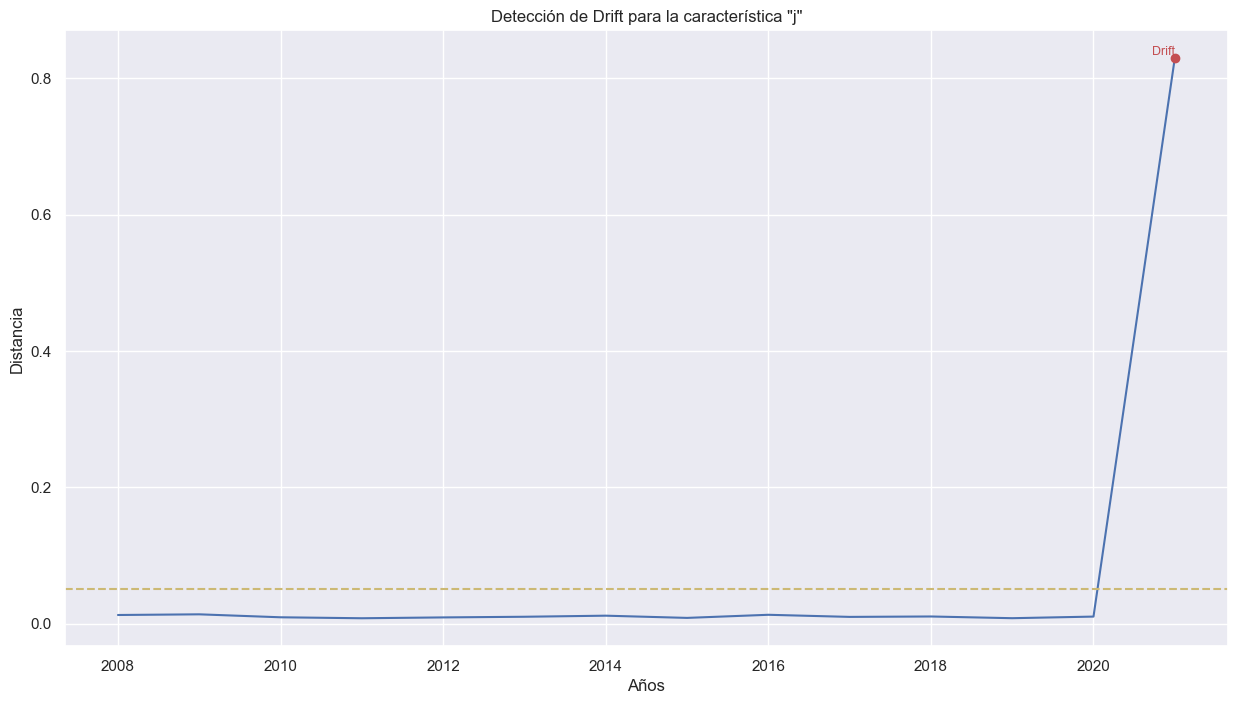

In [36]:
year = np.array(range(2008,2022))
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
values_df = pd.DataFrame(columns = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"])

for feat in range(len(features)):
    js_detector = JS()
    _ = js_detector.fit(X=np.array(X_ref.iloc[:,feat]))
    
    distances = []
    
    for i, batch in enumerate(batch_generator(np.array(X_t0.iloc[:,feat]), 20000)):
        drift_detection = js_detector.compare(batch)
        distances.append(drift_detection[0].distance)
    
        if drift_detection[0].distance  > 0.05:
            print(f"Drift detectado en el año {year[i]} con una distancia de {drift_detection[0].distance}")
        else:
            print(f"No se detectó drift en el año {year[i]} con una distancia de {drift_detection[0].distance}")
    values_df[features[feat]] = distances
    plot_drift_detection2(year, distances, features[feat])

In [37]:
heatmap_data = values_df.transpose()

In [38]:
heatmap_data.columns = year

In [39]:
sns.set(rc={"figure.figsize": (15, 8)})

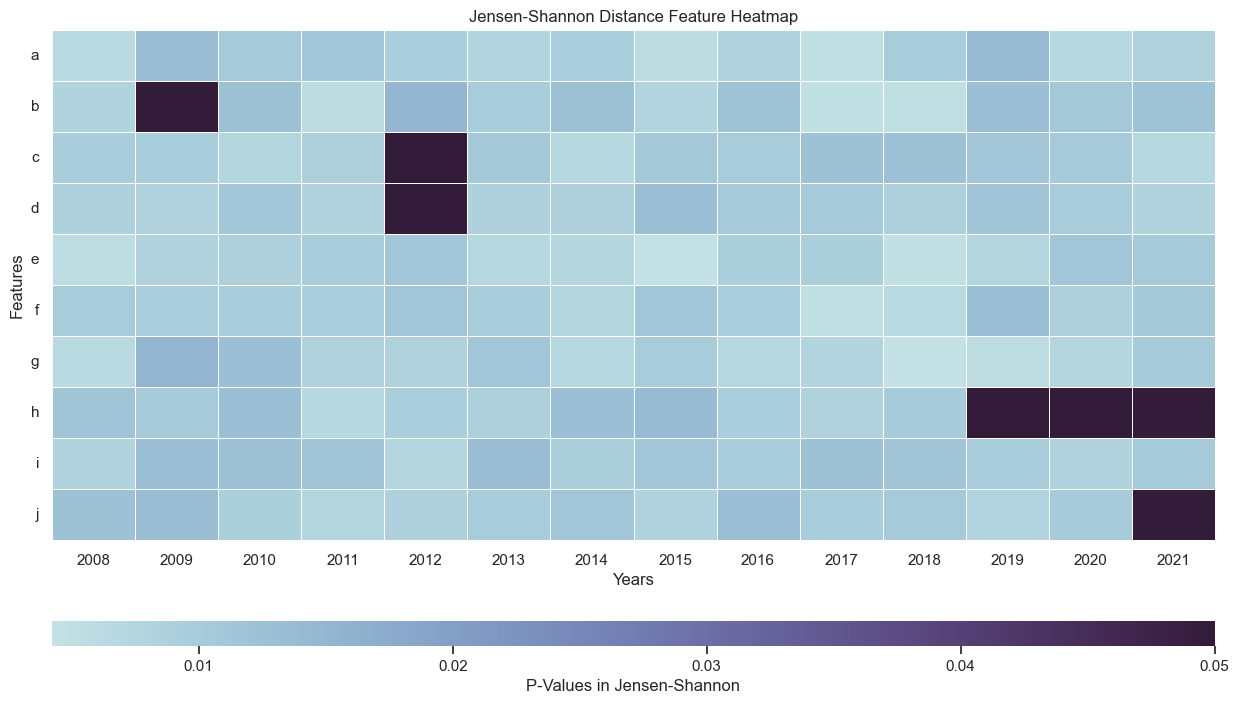

In [40]:
# Setup plot
grid_kws = {"height_ratios": (20, 1), "hspace": 0.3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
coloring = sns.cubehelix_palette(start = 0.5, rot = -0.4, as_cmap=True)
ax = sns.heatmap(
    heatmap_data,
    ax=ax,
    cmap=coloring,
    vmax = 0.05,
    xticklabels=heatmap_data.columns,
    yticklabels=heatmap_data.index,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal"},
)

ax.set_title('Jensen-Shannon Distance Feature Heatmap')
ax.set(xlabel="Years", ylabel="Features")
ax.collections[0].colorbar.set_label("P-Values in Jensen-Shannon")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()